In [3]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline


## PART 1: Camera calibration matrix and distortion coefficients given a set of chessboard images.

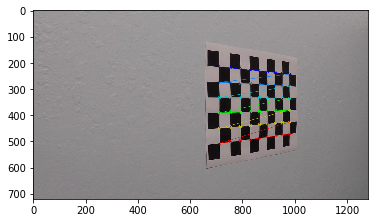

In [4]:
import glob
images = glob.glob('/Users/kathan/udacity/Term-1/CarND-Term1-Starter-Kit/Advance Lane Finding/CarND-Advanced-Lane-Lines-master/camera_cal/calibration*.jpg')

objpoints = [] #3D points in real world space
imgpoints = [] #2D points in image plane
nx = 6 #enter the number of inside corners in x
ny = 9 #enter the number of inside corners in y


#Prepare object points like (0,0,0),(1,0,0) etc..
objp = np.zeros((6*9,3),np.float32)
#Third column will always be zero. No need to change. Need to populate x and y column. Use mgrid of numpy.
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)#x,y coordinate

#Now we have to create image points. For that we have to detect the corners of the board.

for fname in images:
    #print (fname)
    
    image = cv2.imread(fname)
    
    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9, 6), None)

    #If there is any corner point then append it to image point array.
    #Also add prepared obj points to object point array
    #These object points are same for for all of the calibration images as they represent  read chessboard
    if ret == True:
        imgpoints.append(corners)
        objpoints.append(objp)

        #Display these corner points on an image
        cv2.drawChessboardCorners(image, (9, 6), corners, ret)
        plt.imshow(image)


    

In [5]:
print (len(imgpoints))
print (len(objpoints))

17
17


In [6]:
#Calibration of camera using object points and image points. It retruns camera matrix and distortion coeff in mtx
#and dist variable resp.
#rvecs and tvecs containts position of camera in real world
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

In [27]:
#Now undistort an image and check it
img = mpimg.imread('/Users/kathan/udacity/Term-1/CarND-Term1-Starter-Kit/Advance Lane Finding/CarND-Advanced-Lane-Lines-master/camera_cal/calibration2.jpg')
dst = cv2.undistort(img, mtx, dist, None, mtx)

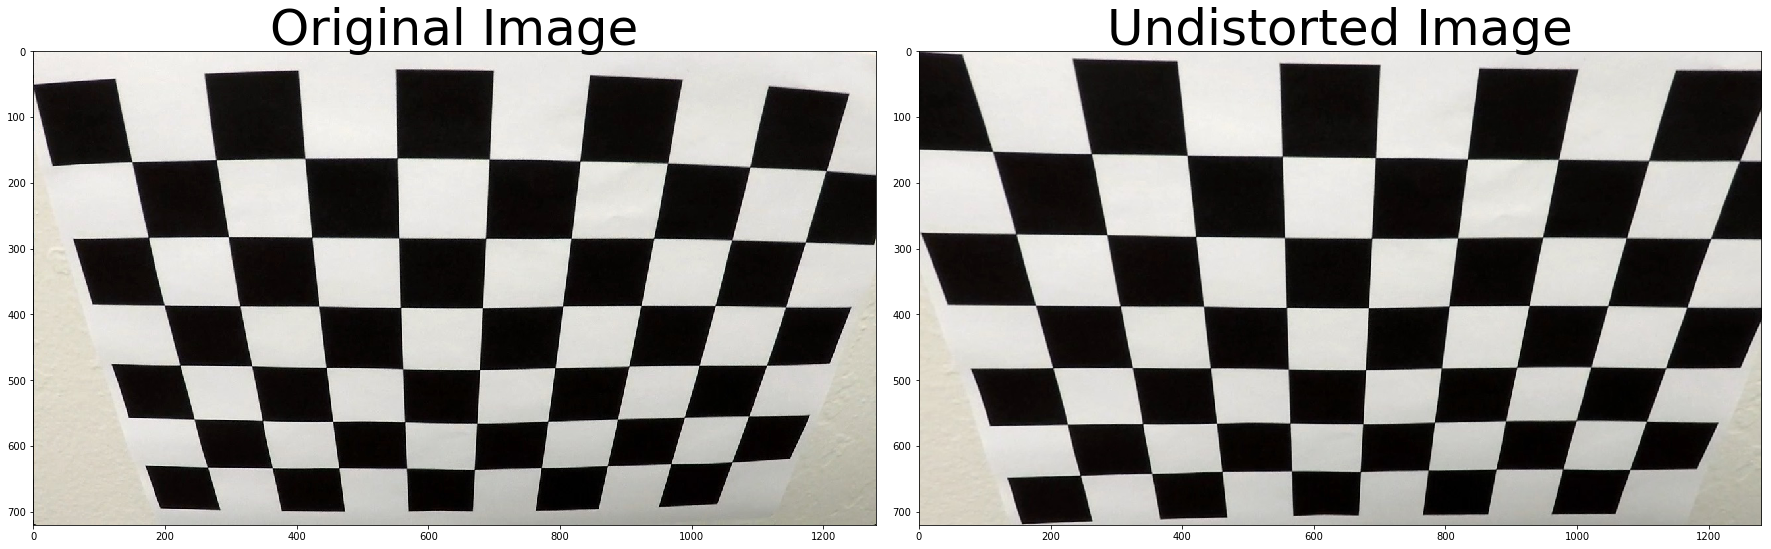

In [28]:

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [29]:
cv2.imwrite("Original.jpg",img)

True

In [30]:
cv2.imwrite("Undistorted.jpg",dst)

True

## PART 2: PIPELINE Functoins

In [31]:
#Undistort an image
def undistort_image(img,mat,dist):
    return cv2.undistort(img,mat,dist,None,mat)

#Color and x gradient thresholding
def threshold_image(img):
    # Convert to HLS color space and separate the S channel
    # Note: img is the undistorted image
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)

    h_channel = hls[:,:,0]
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]

    hsv1 = cv2.cvtColor(img,cv2.COLOR_RGB2HSV)
    h_hsv_channel1 = hsv1[:,:,0]
    s_hsv_channel1 = hsv1[:,:,1]
    v_hsv_channel1 = hsv1[:,:,2]

    r = img[:,:,0]
    g = img[:,:,1]
    b = img[:,:,2]

    # Grayscale image
    # NOTE: we already saw that standard grayscaling lost color information for the lane lines
    # Explore gradients in other colors spaces / color channels to see what might work better
    gray1 = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Sobel x
    sobelx1 = cv2.Sobel(gray1, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx1 = np.absolute(sobelx1) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel1 = np.uint8(255*abs_sobelx1/np.max(abs_sobelx1))

    # Threshold x gradient
    #thresh_min1 = 24
    #thresh_max1 = 110
    #thresh_min1 = 40
    #thresh_max1 = 100
    thresh_min1 = 40
    thresh_max1 = 100
    
    sxbinary1 = np.zeros_like(scaled_sobel1)
    sxbinary1[(scaled_sobel1 >= thresh_min1) & (scaled_sobel1 <= thresh_max1)] = 1

    # Threshold color channel
    #s_thresh_min1 = 165
    #s_thresh_max1 = 254
    #s_thresh_min1 = 160
    #s_thresh_max1 = 254
    s_thresh_min1 = 170
    s_thresh_max1 = 180
    
    
    s_binary1 = np.zeros_like(s_channel)
    s_binary1[(s_channel >= s_thresh_min1) & (s_channel <= s_thresh_max1)] = 1

    # Stack each channel to view their individual contributions in green and blue respectively
    # This returns a stack of the two binary images, whose components you can see as different colors
    color_binary1 = np.dstack(( np.zeros_like(sxbinary1), sxbinary1, s_binary1)) * 255

    # Combine the two binary thresholds
    combined_binary1 = np.zeros_like(sxbinary1)
    combined_binary1[(s_binary1 == 1) | (sxbinary1 == 1)] = 1
    
    return combined_binary1,color_binary1

#Perspective transformation
def transform_image(img):
    
    src_points = np.float32([[705,460],[1110,720],[205,720],[580,460]])
    dst_points = np.float32([[960,0],[960,720],[320,720],[320,0]])
    img_size = (img.shape[1],img.shape[0])
    M = cv2.getPerspectiveTransform(src_points, dst_points)
    Minv = cv2.getPerspectiveTransform(dst_points,src_points)
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    return warped,Minv

#Find Region of Interest
def mask_image(img):
    vertices = np.array([[(100,720),(200,0), (1150, 0), (1200,720)]], dtype=np.int32)
    #defining a blank mask to start with
    mask = np.zeros_like(img)   

    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255

    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)

    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)

    #plt.imshow(masked_image)
    return masked_image

#Use Histogram method to find lane lines
def find_histogram(img):
    histogram = np.sum(img[img.shape[0]//2:,:], axis=0)
    midpoint = np.int(histogram.shape[0]/2)
    print (midpoint)

    leftx_base = np.argmax(histogram[:midpoint])
    print (leftx_base)

    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    print (rightx_base)
    
    return histogram,midpoint,leftx_base,rightx_base


def find_lanes(img,out_img,leftx_base,rightx_base):
    #Choose the number of sliding windows
    nwindows = 9

    #Set height of windows
    window_height = np.int(img.shape[0]/nwindows)

    #Identify x and y positions of all nonzero pixels in the image
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 78
    # Set minimum number of pixels found to recenter window
    #minpix = 50
    minpix = 10
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = img.shape[0] - (window+1)*window_height
        win_y_high = img.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, img.shape[0]-1, img.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    plt.imshow(out_img)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)
    
    return left_fitx,right_fitx,left_lane_inds,right_lane_inds,nonzerox,nonzeroy,ploty

#Visulizing lane lines
def visualize_lane_lines(img,out_img,left_fitx,right_fitx,left_lane_inds,right_lane_inds,nonzerox,nonzeroy,ploty):
    # Create an image to draw on and an image to show the selection window
    #margin = 100
    margin = 60
    # Set minimum number of pixels found to recenter window
    minpix = 50
    
    out_img = np.dstack((img, img, img))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                                  ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                                  ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    plt.imshow(result)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)

#Merging with original image for final output image
def merged_image(img,original,Minv,left_fitx,right_fitx,ploty):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(img).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(original, 1, newwarp, 0.3, 0)
    plt.imshow(result)
    return result
    
    
    



## PART 3 : Pipeline for an Image

(720, 1280, 3)


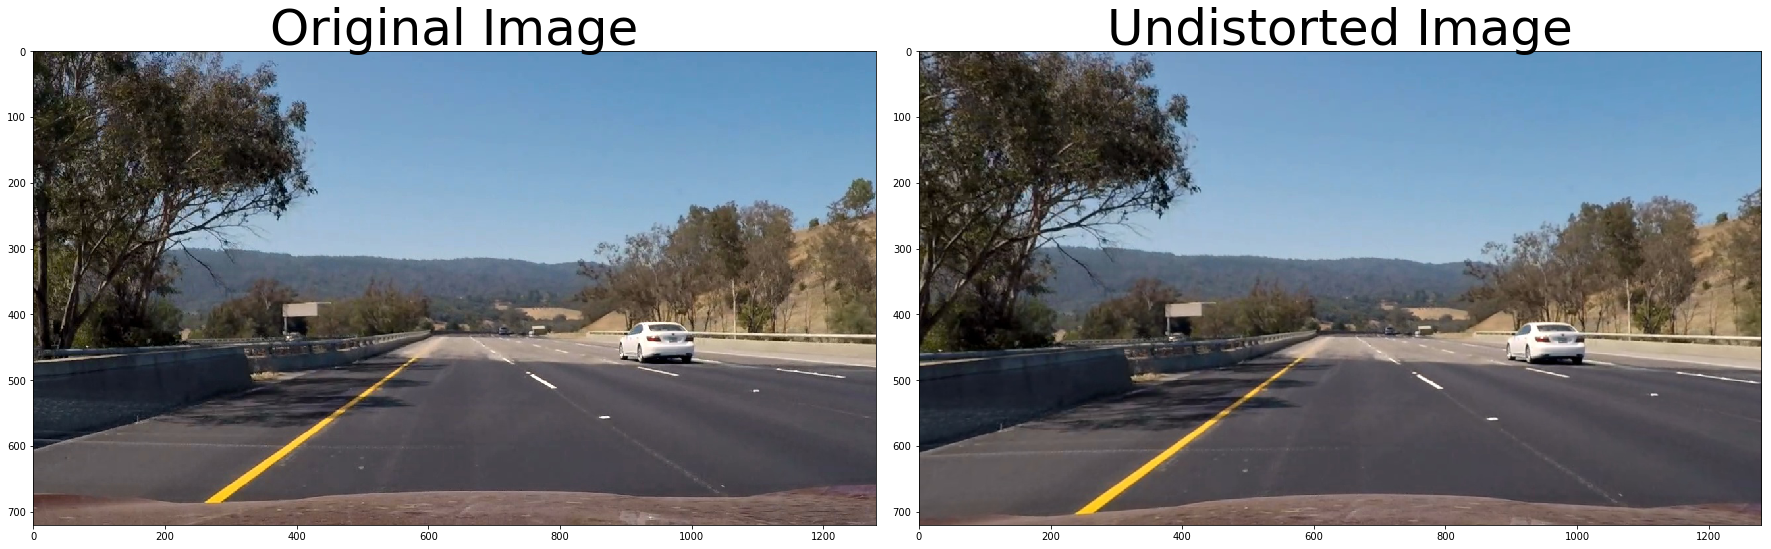

In [10]:
#test1 = mpimg.imread('/Users/kathan/udacity/Term-1/CarND-Term1-Starter-Kit/Advance Lane Finding/CarND-Advanced-Lane-Lines-master/test_images/test4.jpg')
test1 = mpimg.imread('/Users/kathan/udacity/Term-1/CarND-Term1-Starter-Kit/Advance Lane Finding/CarND-Advanced-Lane-Lines-master/frame530.jpg')
print (test1.shape)


#test_dst = cv2.undistort(test1, mtx, dist, None, mtx)
test_dst = undistort_image(test1,mtx,dist)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(test1)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(test_dst)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

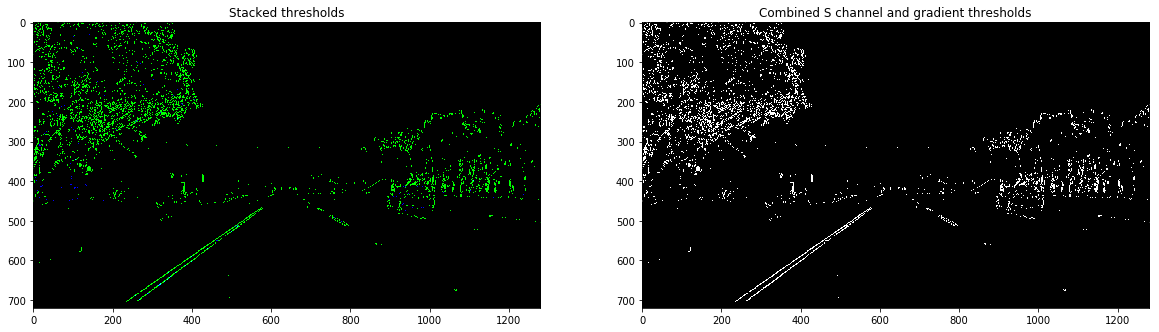

In [11]:

combined,color = threshold_image(test_dst)
# Plotting thresholded images
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_title('Stacked thresholds')
ax1.imshow(color)
ax2.set_title('Combined S channel and gradient thresholds')
ax2.imshow(combined, cmap='gray')



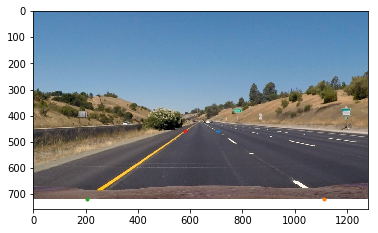

In [32]:
straight_image = mpimg.imread('/Users/kathan/udacity/Term-1/CarND-Term1-Starter-Kit/Advance Lane Finding/CarND-Advanced-Lane-Lines-master/test_images/straight_lines1.jpg')

plt.imshow(straight_image)
plt.plot(705,460,'.') #Top right
plt.plot(1110,720,'.') #Bottom right
plt.plot(205,720,'.') #Bottom left
plt.plot(580,460,'.') #Top left




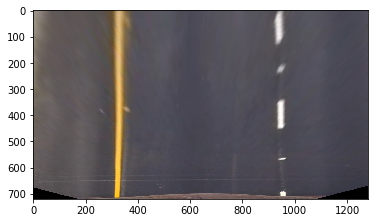

In [33]:
straight_image_dst = cv2.undistort(straight_image, mtx, dist, None, mtx)
src_points = np.float32([[705,460],[1110,720],[205,720],[580,460]])
##src_points = np.float32([[695,460],[1127,720],[203,720],[585,460]])
dst_points = np.float32([[960,0],[960,720],[320,720],[320,0]])
##dst_points = np.float32([[960,0],[960,720],[320,720],[320,0]])

img_size = (straight_image.shape[1],straight_image.shape[0])
M1 = cv2.getPerspectiveTransform(src_points, dst_points)
Minv1 = cv2.getPerspectiveTransform(dst_points,src_points)
straight_warped = cv2.warpPerspective(straight_image_dst, M1, img_size, flags=cv2.INTER_LINEAR)

plt.imshow(straight_warped)




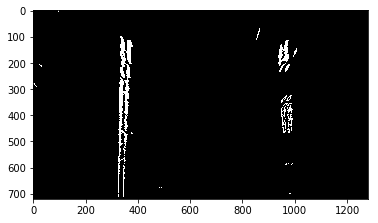

In [15]:
#Perspective Transformation
warped_image,Minv = transform_image(combined)
plt.imshow(warped_image,cmap='gray')



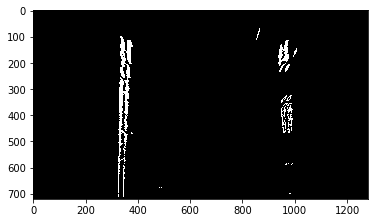

In [34]:
#Masking an image
masked_image = mask_image(warped_image)
plt.imshow(masked_image,cmap="gray")

640
330
977


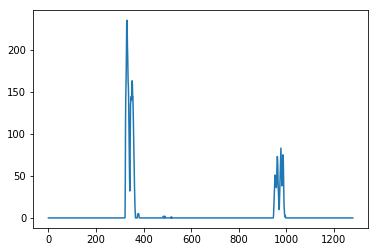

In [17]:
#Find Histogram
histogram_image,midpoint,leftx_base,rightx_base = find_histogram(masked_image)
plt.plot(histogram_image)

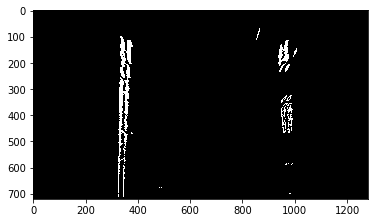

In [18]:
# Create an output image to draw on and  visualize the result
out_img = np.dstack((masked_image, masked_image, masked_image))*255

plt.imshow(out_img)



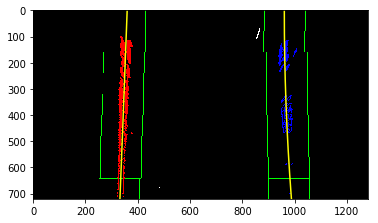

In [19]:
#Visualization of sliding window image
left_fitx,right_fitx,left_lane_inds,right_lane_inds,nonzerox,nonzeroy,ploty = find_lanes(masked_image,out_img,leftx_base,rightx_base)

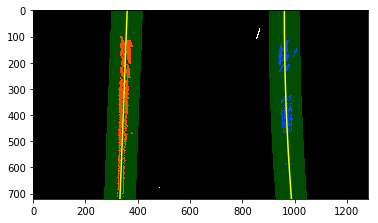

In [20]:

visualize_lane_lines(masked_image,out_img,left_fitx,right_fitx,left_lane_inds,right_lane_inds,nonzerox,nonzeroy,ploty)

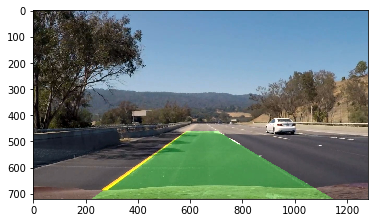

In [21]:
#Final output
final_image = merged_image(masked_image,test1,Minv,left_fitx,right_fitx,ploty)

In [22]:
##Code to Store video in frames

#import cv2
#vidcap = cv2.VideoCapture('project_video.mp4')
#success,image = vidcap.read()
#count = 0
#success = True
#while success:
#    success,image = vidcap.read()
#    print('Read a new frame: ', success)
#    cv2.imwrite("frame%d.jpg" % count, image)     # save frame as JPEG file
#    count += 1

## PIPELINE for Video

In [23]:
def process_image(img):
    undist = undistort_image(img,mtx,dist)
    combined,color = threshold_image(undist)
    
    warped_image,Minv = transform_image(combined)
    masked_image = mask_image(warped_image)
    histogram_image,midpoint,leftx_base,rightx_base = find_histogram(masked_image)  
    out_img = np.dstack((warped_image, warped_image, warped_image))*255
    left_fitx,right_fitx,left_lane_inds,right_lane_inds,nonzerox,nonzeroy,ploty = find_lanes(warped_image,out_img,leftx_base,rightx_base)
    final_result = merged_image(warped_image,img,Minv,left_fitx,right_fitx,ploty)
    return final_result
    
    
    

In [24]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

640
383
1023
[MoviePy] >>>> Building video output_video/project_video_output_trial3.mp4
[MoviePy] Writing video output_video/project_video_output_trial3.mp4


  0%|          | 0/1261 [00:00<?, ?it/s]

640
383
1023


  0%|          | 1/1261 [00:00<03:15,  6.45it/s]

640
385
1001


  0%|          | 2/1261 [00:00<03:12,  6.53it/s]

640
366
1025


  0%|          | 3/1261 [00:00<03:21,  6.25it/s]

640
368
1003


  0%|          | 4/1261 [00:00<03:26,  6.10it/s]

640
369
1008


  0%|          | 5/1261 [00:00<03:28,  6.02it/s]

640
371
964


  0%|          | 6/1261 [00:00<03:28,  6.03it/s]

640
388
969


  1%|          | 7/1261 [00:01<03:30,  5.96it/s]

640
371
969


  1%|          | 8/1261 [00:01<03:33,  5.86it/s]

640
371
975


  1%|          | 9/1261 [00:01<03:42,  5.64it/s]

640
368
980


  1%|          | 10/1261 [00:01<03:36,  5.77it/s]

640
369
1003


  1%|          | 11/1261 [00:01<03:31,  5.91it/s]

640
367
1012


  1%|          | 12/1261 [00:02<03:32,  5.88it/s]

640
369
1014


  1%|          | 13/1261 [00:02<03:31,  5.90it/s]

640
370
996


  1%|          | 14/1261 [00:02<03:32,  5.87it/s]

640
362
994


  1%|          | 15/1261 [00:02<03:31,  5.88it/s]

640
365
994


  1%|▏         | 16/1261 [00:02<03:31,  5.88it/s]

640
366
997


  1%|▏         | 17/1261 [00:02<03:26,  6.03it/s]

640
368
1000


  1%|▏         | 18/1261 [00:03<03:30,  5.91it/s]

640
369
965


  2%|▏         | 19/1261 [00:03<03:29,  5.92it/s]

640
369
972


  2%|▏         | 20/1261 [00:03<03:29,  5.91it/s]

640
359
978


  2%|▏         | 21/1261 [00:03<03:29,  5.91it/s]

640
351
988


  2%|▏         | 22/1261 [00:03<03:28,  5.95it/s]

640
347
995


  2%|▏         | 23/1261 [00:03<03:26,  6.01it/s]

640
351
998


  2%|▏         | 24/1261 [00:04<03:16,  6.30it/s]

640
351
1001


  2%|▏         | 25/1261 [00:04<03:10,  6.50it/s]

640
350
987


  2%|▏         | 26/1261 [00:04<03:07,  6.60it/s]

640
351
1012


  2%|▏         | 27/1261 [00:04<03:08,  6.53it/s]

640
350
998


  2%|▏         | 28/1261 [00:04<03:07,  6.56it/s]

640
354
1020


  2%|▏         | 29/1261 [00:04<03:03,  6.73it/s]

640
344
1020


  2%|▏         | 30/1261 [00:04<03:00,  6.82it/s]

640
346
1021


  2%|▏         | 31/1261 [00:05<02:57,  6.93it/s]

640
351
952


  3%|▎         | 32/1261 [00:05<02:57,  6.93it/s]

640
371
972


  3%|▎         | 33/1261 [00:05<02:57,  6.90it/s]

640
353
961


  3%|▎         | 34/1261 [00:05<02:54,  7.03it/s]

640
353
990


  3%|▎         | 35/1261 [00:05<02:51,  7.13it/s]

640
356
992


  3%|▎         | 36/1261 [00:05<02:52,  7.11it/s]

640
357
999


  3%|▎         | 37/1261 [00:05<03:06,  6.58it/s]

640
359
1001


  3%|▎         | 38/1261 [00:06<03:13,  6.31it/s]

640
360
977


  3%|▎         | 39/1261 [00:06<03:18,  6.15it/s]

640
360
1004


  3%|▎         | 40/1261 [00:06<03:23,  6.01it/s]

640
360
988


  3%|▎         | 41/1261 [00:06<03:23,  6.00it/s]

640
361
1015


  3%|▎         | 42/1261 [00:06<03:13,  6.29it/s]

640
362
999


  3%|▎         | 43/1261 [00:06<03:13,  6.29it/s]

640
361
951


  3%|▎         | 44/1261 [00:07<03:17,  6.18it/s]

640
362
956


  4%|▎         | 45/1261 [00:07<03:28,  5.82it/s]

640
361
958


  4%|▎         | 46/1261 [00:07<03:34,  5.66it/s]

640

  4%|▎         | 47/1261 [00:07<03:41,  5.47it/s]


360
992
640
361
993


  4%|▍         | 48/1261 [00:07<03:44,  5.40it/s]

640
357
998


  4%|▍         | 49/1261 [00:08<03:36,  5.59it/s]

640
361
1002


  4%|▍         | 50/1261 [00:08<03:27,  5.83it/s]

640
362
1007


  4%|▍         | 51/1261 [00:08<03:19,  6.08it/s]

640
362
984


  4%|▍         | 52/1261 [00:08<03:16,  6.14it/s]

640
363
986


  4%|▍         | 53/1261 [00:08<03:15,  6.18it/s]

640
358
1010


  4%|▍         | 54/1261 [00:08<03:13,  6.24it/s]

640
363
1015


  4%|▍         | 55/1261 [00:08<03:06,  6.47it/s]

640
361
942


  4%|▍         | 56/1261 [00:09<03:06,  6.46it/s]

640
354
947


  5%|▍         | 57/1261 [00:09<03:04,  6.54it/s]

640
343
954


  5%|▍         | 58/1261 [00:09<03:04,  6.50it/s]

640
360
955


  5%|▍         | 59/1261 [00:09<03:03,  6.53it/s]

640
344
948


  5%|▍         | 60/1261 [00:09<03:03,  6.54it/s]

640
347
978


  5%|▍         | 61/1261 [00:09<03:02,  6.56it/s]

640
350
966


  5%|▍         | 62/1261 [00:09<03:03,  6.53it/s]

640
350
982


  5%|▍         | 63/1261 [00:10<03:01,  6.58it/s]

640
352
985


  5%|▌         | 64/1261 [00:10<02:58,  6.69it/s]

640
353
972


  5%|▌         | 65/1261 [00:10<02:58,  6.68it/s]

640
355
994


  5%|▌         | 66/1261 [00:10<02:56,  6.76it/s]

640
353
998


  5%|▌         | 67/1261 [00:10<02:59,  6.64it/s]

640
350
923


  5%|▌         | 68/1261 [00:10<02:59,  6.64it/s]

640
344
924


  5%|▌         | 69/1261 [00:11<03:01,  6.57it/s]

640
344
931


  6%|▌         | 70/1261 [00:11<03:00,  6.61it/s]

640
345
933


  6%|▌         | 71/1261 [00:11<03:00,  6.60it/s]

640
345
939


  6%|▌         | 72/1261 [00:11<02:59,  6.62it/s]

640
345
943


  6%|▌         | 73/1261 [00:11<02:59,  6.62it/s]

640
345
949


  6%|▌         | 74/1261 [00:11<02:59,  6.60it/s]

640
344
958


  6%|▌         | 75/1261 [00:11<03:02,  6.51it/s]

640
345
958


  6%|▌         | 76/1261 [00:12<03:00,  6.56it/s]

640
344
966


  6%|▌         | 77/1261 [00:12<03:03,  6.47it/s]

640
343
970


  6%|▌         | 78/1261 [00:12<03:01,  6.50it/s]

640
342
974


  6%|▋         | 79/1261 [00:12<03:02,  6.47it/s]

640
328
996


  6%|▋         | 80/1261 [00:12<03:01,  6.51it/s]

640
331
977


  6%|▋         | 81/1261 [00:12<03:00,  6.52it/s]

640
326
938


  7%|▋         | 82/1261 [00:13<02:58,  6.59it/s]

640
328
942


  7%|▋         | 83/1261 [00:13<03:01,  6.49it/s]

640
324
951


  7%|▋         | 84/1261 [00:13<03:00,  6.52it/s]

640
329
956


  7%|▋         | 85/1261 [00:13<03:01,  6.49it/s]

640
325
959


  7%|▋         | 86/1261 [00:13<03:07,  6.26it/s]

640
332
980


  7%|▋         | 87/1261 [00:13<03:08,  6.24it/s]

640
328
980


  7%|▋         | 88/1261 [00:13<03:10,  6.17it/s]

640
350
961


  7%|▋         | 89/1261 [00:14<03:05,  6.31it/s]

640
352
983


  7%|▋         | 90/1261 [00:14<03:03,  6.40it/s]

640
352
969


  7%|▋         | 91/1261 [00:14<03:00,  6.47it/s]

640
353
971


  7%|▋         | 92/1261 [00:14<02:59,  6.52it/s]

640
354
992


  7%|▋         | 93/1261 [00:14<02:58,  6.53it/s]

640
355
924


  7%|▋         | 94/1261 [00:14<02:57,  6.56it/s]

640
355
928


  8%|▊         | 95/1261 [00:15<03:00,  6.47it/s]

640
355
934


  8%|▊         | 96/1261 [00:15<02:59,  6.50it/s]

640
356
940


  8%|▊         | 97/1261 [00:15<03:01,  6.41it/s]

640
356
946


  8%|▊         | 98/1261 [00:15<03:00,  6.44it/s]

640
358
948


  8%|▊         | 99/1261 [00:15<02:59,  6.48it/s]

640
358
974


  8%|▊         | 100/1261 [00:15<02:59,  6.45it/s]

640
340
957


  8%|▊         | 101/1261 [00:15<02:59,  6.47it/s]

640
342
961


  8%|▊         | 102/1261 [00:16<03:00,  6.44it/s]

640
342
965


  8%|▊         | 103/1261 [00:16<03:00,  6.42it/s]

640
344
988


  8%|▊         | 104/1261 [00:16<02:58,  6.47it/s]

640
343
994


  8%|▊         | 105/1261 [00:16<02:56,  6.54it/s]

640
344
978


  8%|▊         | 106/1261 [00:16<02:55,  6.59it/s]

640
344
980


  8%|▊         | 107/1261 [00:16<02:57,  6.51it/s]

640
345
971


  9%|▊         | 108/1261 [00:17<02:55,  6.59it/s]

640
346
973


  9%|▊         | 109/1261 [00:17<02:55,  6.55it/s]

640
365
979


  9%|▊         | 110/1261 [00:17<02:53,  6.62it/s]

640
366
962


  9%|▉         | 111/1261 [00:17<02:54,  6.60it/s]

640
364
993


  9%|▉         | 112/1261 [00:17<02:53,  6.61it/s]

640
367
992


  9%|▉         | 113/1261 [00:17<02:54,  6.58it/s]

640
368
974


  9%|▉         | 114/1261 [00:17<02:54,  6.57it/s]

640
369
976


  9%|▉         | 115/1261 [00:18<02:55,  6.52it/s]

640
370
978


  9%|▉         | 116/1261 [00:18<02:55,  6.52it/s]

640
370
981


  9%|▉         | 117/1261 [00:18<02:53,  6.59it/s]

640
372
1004


  9%|▉         | 118/1261 [00:18<02:52,  6.61it/s]

640
373
987


  9%|▉         | 119/1261 [00:18<02:53,  6.59it/s]

640
375
946


 10%|▉         | 120/1261 [00:18<02:56,  6.45it/s]

640
356
951


 10%|▉         | 121/1261 [00:19<02:54,  6.55it/s]

640
377
956


 10%|▉         | 122/1261 [00:19<02:51,  6.63it/s]

640
359
980


 10%|▉         | 123/1261 [00:19<02:50,  6.66it/s]

640
360
963


 10%|▉         | 124/1261 [00:19<02:53,  6.56it/s]

640
361
989


 10%|▉         | 125/1261 [00:19<02:53,  6.56it/s]

640
361
997


 10%|▉         | 126/1261 [00:19<02:52,  6.59it/s]

640
362
1000


 10%|█         | 127/1261 [00:19<02:50,  6.63it/s]

640
362
1006


 10%|█         | 128/1261 [00:20<02:52,  6.57it/s]

640
364
986


 10%|█         | 129/1261 [00:20<02:55,  6.45it/s]

640
364
1010


 10%|█         | 130/1261 [00:20<02:55,  6.46it/s]

640
365
1012


 10%|█         | 131/1261 [00:20<02:53,  6.50it/s]

640
366
964


 10%|█         | 132/1261 [00:20<02:52,  6.55it/s]

640
366
959


 11%|█         | 133/1261 [00:20<02:52,  6.52it/s]

640
368
964


 11%|█         | 134/1261 [00:21<02:55,  6.44it/s]

640
369
972


 11%|█         | 135/1261 [00:21<02:53,  6.49it/s]

640
367
967


 11%|█         | 136/1261 [00:21<02:55,  6.42it/s]

640
366
995


 11%|█         | 137/1261 [00:21<02:58,  6.29it/s]

640
367
1002


 11%|█         | 138/1261 [00:21<02:57,  6.33it/s]

640
366
984


 11%|█         | 139/1261 [00:21<02:55,  6.40it/s]

640
363
994


 11%|█         | 140/1261 [00:21<02:55,  6.40it/s]

640
366
1016


 11%|█         | 141/1261 [00:22<02:52,  6.51it/s]

640
366
997


 11%|█▏        | 142/1261 [00:22<02:50,  6.56it/s]

640
367
998


 11%|█▏        | 143/1261 [00:22<02:50,  6.55it/s]

640
357
1019


 11%|█▏        | 144/1261 [00:22<02:49,  6.59it/s]

640
359
953


 11%|█▏        | 145/1261 [00:22<02:49,  6.58it/s]

640
362
952


 12%|█▏        | 146/1261 [00:22<02:49,  6.59it/s]

640
363
958


 12%|█▏        | 147/1261 [00:23<02:50,  6.55it/s]

640
365
957


 12%|█▏        | 148/1261 [00:23<02:50,  6.52it/s]

640
365
962


 12%|█▏        | 149/1261 [00:23<02:50,  6.51it/s]

640
365
970


 12%|█▏        | 150/1261 [00:23<02:52,  6.46it/s]

640
361
976


 12%|█▏        | 151/1261 [00:23<02:53,  6.41it/s]

640
361
980


 12%|█▏        | 152/1261 [00:23<02:52,  6.45it/s]

640
363
983


 12%|█▏        | 153/1261 [00:23<02:52,  6.41it/s]

640
361
1010


 12%|█▏        | 154/1261 [00:24<02:51,  6.47it/s]

640
361
1017


 12%|█▏        | 155/1261 [00:24<02:50,  6.48it/s]

640
361
1015


 12%|█▏        | 156/1261 [00:24<02:52,  6.42it/s]

640
357
976


 12%|█▏        | 157/1261 [00:24<02:52,  6.39it/s]

640
359
975


 13%|█▎        | 158/1261 [00:24<02:52,  6.41it/s]

640
355
980


 13%|█▎        | 159/1261 [00:24<02:50,  6.46it/s]

640
356
964


 13%|█▎        | 160/1261 [00:25<02:48,  6.55it/s]

640
348
987


 13%|█▎        | 161/1261 [00:25<02:46,  6.61it/s]

640
350
990


 13%|█▎        | 162/1261 [00:25<02:47,  6.58it/s]

640
347
1001


 13%|█▎        | 163/1261 [00:25<02:50,  6.46it/s]

640
350
998


 13%|█▎        | 164/1261 [00:25<02:51,  6.40it/s]

640
352
977


 13%|█▎        | 165/1261 [00:25<02:54,  6.28it/s]

640
350
981


 13%|█▎        | 166/1261 [00:25<02:53,  6.31it/s]

640
351
983


 13%|█▎        | 167/1261 [00:26<02:54,  6.28it/s]

640
348
1009


 13%|█▎        | 168/1261 [00:26<02:53,  6.32it/s]

640
344
939


 13%|█▎        | 169/1261 [00:26<02:52,  6.34it/s]

640
343
947


 13%|█▎        | 170/1261 [00:26<02:53,  6.30it/s]

640
346
949


 14%|█▎        | 171/1261 [00:26<02:50,  6.40it/s]

640
344
953


 14%|█▎        | 172/1261 [00:26<02:51,  6.35it/s]

640
345
977


 14%|█▎        | 173/1261 [00:27<02:51,  6.34it/s]

640
345
976


 14%|█▍        | 174/1261 [00:27<02:53,  6.27it/s]

640
345
982


 14%|█▍        | 175/1261 [00:27<02:50,  6.35it/s]

640
342
962


 14%|█▍        | 176/1261 [00:27<02:50,  6.35it/s]

640
340
991


 14%|█▍        | 177/1261 [00:27<02:50,  6.36it/s]

640
331
976


 14%|█▍        | 178/1261 [00:27<02:50,  6.37it/s]

640
336
981


 14%|█▍        | 179/1261 [00:28<02:52,  6.26it/s]

640
333
1008


 14%|█▍        | 180/1261 [00:28<02:50,  6.32it/s]

640
336
989


 14%|█▍        | 181/1261 [00:28<02:53,  6.23it/s]

640
338
976


 14%|█▍        | 182/1261 [00:28<02:52,  6.25it/s]

640
341
977


 15%|█▍        | 183/1261 [00:28<02:50,  6.33it/s]

640
350
964


 15%|█▍        | 184/1261 [00:28<02:50,  6.32it/s]

640
354
965


 15%|█▍        | 185/1261 [00:28<02:45,  6.48it/s]

640
361
968


 15%|█▍        | 186/1261 [00:29<02:44,  6.52it/s]

640
361
972


 15%|█▍        | 187/1261 [00:29<02:43,  6.56it/s]

640
363
966


 15%|█▍        | 188/1261 [00:29<02:43,  6.55it/s]

640
364
971


 15%|█▍        | 189/1261 [00:29<02:45,  6.48it/s]

640
348
977


 15%|█▌        | 190/1261 [00:29<02:45,  6.48it/s]

640
351
980


 15%|█▌        | 191/1261 [00:29<02:44,  6.51it/s]

640
352
1004


 15%|█▌        | 192/1261 [00:30<02:45,  6.45it/s]

640
356
941


 15%|█▌        | 193/1261 [00:30<02:46,  6.41it/s]

640
357
934


 15%|█▌        | 194/1261 [00:30<02:47,  6.39it/s]

640
358
943


 15%|█▌        | 195/1261 [00:30<02:45,  6.43it/s]

640
355
955


 16%|█▌        | 196/1261 [00:30<02:46,  6.40it/s]

640
352
957


 16%|█▌        | 197/1261 [00:30<02:46,  6.37it/s]

640
347
970


 16%|█▌        | 198/1261 [00:31<02:48,  6.29it/s]

640
347
1000


 16%|█▌        | 199/1261 [00:31<02:46,  6.37it/s]

640
346
1007


 16%|█▌        | 200/1261 [00:31<02:47,  6.34it/s]

640
336
1009


 16%|█▌        | 201/1261 [00:31<02:48,  6.30it/s]

640
332
1007


 16%|█▌        | 202/1261 [00:31<02:46,  6.35it/s]

640
336
987


 16%|█▌        | 203/1261 [00:31<02:46,  6.34it/s]

640
335
1010


 16%|█▌        | 204/1261 [00:31<02:46,  6.35it/s]

640
341
1011


 16%|█▋        | 205/1261 [00:32<02:45,  6.39it/s]

640
342
961


 16%|█▋        | 206/1261 [00:32<02:47,  6.29it/s]

640
344
961


 16%|█▋        | 207/1261 [00:32<02:47,  6.30it/s]

640
346
952


 16%|█▋        | 208/1261 [00:32<02:45,  6.35it/s]

640
346
944


 17%|█▋        | 209/1261 [00:32<02:44,  6.39it/s]

640
346
972


 17%|█▋        | 210/1261 [00:32<02:46,  6.33it/s]

640
339
991


 17%|█▋        | 211/1261 [00:33<02:45,  6.33it/s]

640
345
966


 17%|█▋        | 212/1261 [00:33<02:48,  6.23it/s]

640
344
992


 17%|█▋        | 213/1261 [00:33<02:45,  6.34it/s]

640
342
995


 17%|█▋        | 214/1261 [00:33<02:45,  6.31it/s]

640
334
977


 17%|█▋        | 215/1261 [00:33<02:43,  6.39it/s]

640
333
980


 17%|█▋        | 216/1261 [00:33<02:46,  6.28it/s]

640
336
1002


 17%|█▋        | 217/1261 [00:34<02:46,  6.26it/s]

640
337
986


 17%|█▋        | 218/1261 [00:34<02:45,  6.30it/s]

640
338
951


 17%|█▋        | 219/1261 [00:34<02:45,  6.30it/s]

640
337
938


 17%|█▋        | 220/1261 [00:34<02:46,  6.25it/s]

640
339
944


 18%|█▊        | 222/1261 [00:34<03:15,  5.31it/s]

640
340
959
640
340
945


 18%|█▊        | 224/1261 [00:35<03:47,  4.56it/s]

640
341
954
640
341
979


 18%|█▊        | 226/1261 [00:35<03:42,  4.66it/s]

640
338
967
640
328
956


 18%|█▊        | 228/1261 [00:36<03:27,  4.97it/s]

640
334
982


 18%|█▊        | 229/1261 [00:36<03:30,  4.91it/s]

640
331
986


 18%|█▊        | 230/1261 [00:36<03:33,  4.82it/s]

640
324
968


 18%|█▊        | 231/1261 [00:36<03:37,  4.74it/s]

640
334
919
640
328
926


 18%|█▊        | 233/1261 [00:37<03:35,  4.77it/s]

640
325
925
640
327
928


 19%|█▊        | 235/1261 [00:37<03:09,  5.42it/s]

640
312
934
640
319
934


 19%|█▉        | 237/1261 [00:37<03:06,  5.48it/s]

640
316
960


 19%|█▉        | 238/1261 [00:38<03:17,  5.19it/s]

640
319
942


 19%|█▉        | 239/1261 [00:38<03:34,  4.77it/s]

640
321
967


 19%|█▉        | 240/1261 [00:38<03:36,  4.71it/s]

640
320
951
640
320
979


 19%|█▉        | 242/1261 [00:39<03:17,  5.17it/s]

640
320
983


 19%|█▉        | 243/1261 [00:39<03:25,  4.96it/s]

640
315
932
640
314
936


 19%|█▉        | 245/1261 [00:39<03:09,  5.36it/s]

640
315
922
640
318
918


 20%|█▉        | 247/1261 [00:39<03:05,  5.47it/s]

640
317
943


 20%|█▉        | 248/1261 [00:40<03:22,  5.01it/s]

640
313
952
640
313
960


 20%|█▉        | 250/1261 [00:40<03:05,  5.44it/s]

640
315
938
640
315
944


 20%|█▉        | 252/1261 [00:40<02:59,  5.63it/s]

640
315
950
640
315
972


 20%|██        | 254/1261 [00:41<02:55,  5.74it/s]

640
315
978
640
317
925


 20%|██        | 256/1261 [00:41<02:46,  6.04it/s]

640
310
932
640
313
925


 20%|██        | 258/1261 [00:41<02:43,  6.15it/s]

640
316
938
640
317
924


 21%|██        | 260/1261 [00:42<02:46,  6.02it/s]

640
319
952
640
319
963


 21%|██        | 262/1261 [00:42<02:43,  6.13it/s]

640
320
967
640
321
950


 21%|██        | 264/1261 [00:42<02:48,  5.92it/s]

640
321
974


 21%|██        | 265/1261 [00:43<02:58,  5.57it/s]

640
333
978
640
333
985


 21%|██        | 267/1261 [00:43<02:50,  5.82it/s]

640
336
986
640
337
957


 21%|██▏       | 269/1261 [00:43<02:46,  5.97it/s]

640
335
964
640
335
968


 21%|██▏       | 271/1261 [00:44<02:53,  5.70it/s]

640
336
971
640
339
972


 22%|██▏       | 273/1261 [00:44<03:31,  4.68it/s]

640
340
973
640
343
953


 22%|██▏       | 275/1261 [00:44<03:06,  5.29it/s]

640
343
963
640
343
965


 22%|██▏       | 277/1261 [00:45<02:47,  5.88it/s]

640
344
988
640
344
994


 22%|██▏       | 279/1261 [00:45<02:40,  6.11it/s]

640
346
955
640
346
960


 22%|██▏       | 281/1261 [00:45<02:33,  6.38it/s]

640
348
963
640
350
969


 22%|██▏       | 283/1261 [00:46<02:32,  6.42it/s]

640
350
976
640
352
981


 23%|██▎       | 285/1261 [00:46<02:28,  6.58it/s]

640
353
988
640
352
994


 23%|██▎       | 287/1261 [00:46<02:30,  6.45it/s]

640
353
997
640
353
1002


 23%|██▎       | 289/1261 [00:47<02:30,  6.46it/s]

640
356
1002
640
356
1004


 23%|██▎       | 291/1261 [00:47<02:32,  6.36it/s]

640
358
972
640
360
975


 23%|██▎       | 293/1261 [00:47<02:31,  6.37it/s]

640
360
981
640
362
982


 23%|██▎       | 295/1261 [00:48<02:29,  6.44it/s]

640
362
987
640
362
990


 24%|██▎       | 297/1261 [00:48<02:31,  6.36it/s]

640
362
993
640
361
997


 24%|██▎       | 299/1261 [00:48<02:30,  6.39it/s]

640
361
979
640
360
1004


 24%|██▍       | 301/1261 [00:48<02:30,  6.38it/s]

640
360
1006
640
357
1009


 24%|██▍       | 303/1261 [00:49<02:29,  6.42it/s]

640
358
990
640
358
960


 24%|██▍       | 305/1261 [00:49<02:28,  6.45it/s]

640
357
966
640
359
964


 24%|██▍       | 307/1261 [00:49<02:29,  6.40it/s]

640
359
992
640
362
991


 25%|██▍       | 309/1261 [00:50<02:29,  6.36it/s]

640
363
996
640
364
979


 25%|██▍       | 311/1261 [00:50<02:30,  6.31it/s]

640
366
1000
640
367
1002


 25%|██▍       | 313/1261 [00:50<02:29,  6.33it/s]

640
351
1000
640
351
1006


 25%|██▍       | 315/1261 [00:51<02:29,  6.34it/s]

640
352
969
640
351
956


 25%|██▌       | 317/1261 [00:51<02:28,  6.38it/s]

640
350
984
640
353
962


 25%|██▌       | 319/1261 [00:51<02:26,  6.42it/s]

640
352
965
640
354
967


 25%|██▌       | 321/1261 [00:52<02:26,  6.43it/s]

640
354
972
640
354
975


 26%|██▌       | 323/1261 [00:52<02:31,  6.18it/s]

640
355
997
640
353
982


 26%|██▌       | 325/1261 [00:52<02:28,  6.31it/s]

640
354
1003
640
353
984


 26%|██▌       | 327/1261 [00:53<02:27,  6.31it/s]

640
352
988
640
350
989


 26%|██▌       | 329/1261 [00:53<02:28,  6.29it/s]

640
347
998
640
349
979


 26%|██▌       | 331/1261 [00:53<02:25,  6.37it/s]

640
349
978
640
352
996


 26%|██▋       | 333/1261 [00:54<02:25,  6.39it/s]

640
353
975
640
353
997


 27%|██▋       | 335/1261 [00:54<02:24,  6.41it/s]

640
353
981
640
351
987


 27%|██▋       | 337/1261 [00:54<02:26,  6.32it/s]

640
351
1008
640
351
992


 27%|██▋       | 339/1261 [00:54<02:25,  6.34it/s]

640
352
991
640
354
993


 27%|██▋       | 341/1261 [00:55<02:25,  6.33it/s]

640
354
974
640
359
970


 27%|██▋       | 343/1261 [00:55<02:24,  6.34it/s]

640
357
973
640
354
980


 27%|██▋       | 345/1261 [00:55<02:21,  6.46it/s]

640
354
982
640
353
986


 28%|██▊       | 347/1261 [00:56<02:21,  6.44it/s]

640
354
984
640
373
1010


 28%|██▊       | 349/1261 [00:56<02:25,  6.25it/s]

640
374
989
640
374
992


 28%|██▊       | 351/1261 [00:56<02:27,  6.17it/s]

640
353
993
640
352
994


 28%|██▊       | 353/1261 [00:57<02:25,  6.24it/s]

640
351
986
640
351
985


 28%|██▊       | 355/1261 [00:57<02:23,  6.31it/s]

640
350
987
640
350
1010


 28%|██▊       | 357/1261 [00:57<02:25,  6.22it/s]

640
353
1008
640
352
987


 28%|██▊       | 359/1261 [00:58<02:21,  6.35it/s]

640
357
1008
640
356
989


 29%|██▊       | 361/1261 [00:58<02:28,  6.08it/s]

640
356
989
640
358
989


 29%|██▉       | 363/1261 [00:58<02:25,  6.17it/s]

640
358
1008
640
361
989


 29%|██▉       | 365/1261 [00:59<02:27,  6.08it/s]

640
360
979
640
360
980


 29%|██▉       | 367/1261 [00:59<02:28,  6.02it/s]

640
359
1006
640
378
1009


 29%|██▉       | 369/1261 [00:59<02:27,  6.06it/s]

640
379
1006
640
377
1005


 29%|██▉       | 371/1261 [01:00<02:30,  5.91it/s]

640
375
1009
640
372
1011


 30%|██▉       | 373/1261 [01:00<02:26,  6.05it/s]

640
370
1013
640
370
988


 30%|██▉       | 375/1261 [01:00<02:24,  6.15it/s]

640
349
987
640
351
963


 30%|██▉       | 377/1261 [01:01<02:24,  6.10it/s]

640
349
966
640
349
972


 30%|███       | 379/1261 [01:01<02:21,  6.25it/s]

640
366
978
640
348
980


 30%|███       | 381/1261 [01:01<02:21,  6.23it/s]

640
365
985
640
347
985


 30%|███       | 383/1261 [01:02<02:23,  6.13it/s]

640
365
981
640
366
984


 31%|███       | 385/1261 [01:02<02:20,  6.26it/s]

640
358
986
640
356
988


 31%|███       | 387/1261 [01:02<02:19,  6.26it/s]

640
352
992
640
353
992


 31%|███       | 389/1261 [01:03<02:19,  6.27it/s]

640
350
982
640
348
984


 31%|███       | 391/1261 [01:03<02:20,  6.20it/s]

640
347
983
640
347
983


 31%|███       | 393/1261 [01:03<02:21,  6.12it/s]

640
367
1004
640
366
1005


 31%|███▏      | 395/1261 [01:03<02:20,  6.18it/s]

640
347
999
640
366
1004


 31%|███▏      | 397/1261 [01:04<02:19,  6.19it/s]

640
365
1006
640
364
983


 32%|███▏      | 399/1261 [01:04<02:19,  6.19it/s]

640
362
986
640
362
987


 32%|███▏      | 401/1261 [01:04<02:19,  6.15it/s]

640
360
992
640
359
993


 32%|███▏      | 403/1261 [01:05<02:22,  6.02it/s]

640
360
974
640
358
977


 32%|███▏      | 405/1261 [01:05<02:50,  5.02it/s]

640
360
998


 32%|███▏      | 406/1261 [01:05<02:41,  5.31it/s]

640
358
996
640
357
1001


 32%|███▏      | 408/1261 [01:06<02:38,  5.39it/s]

640
356
1000
640
355
1000


 33%|███▎      | 410/1261 [01:06<02:25,  5.83it/s]

640
356
976
640
354
995


 33%|███▎      | 412/1261 [01:06<02:20,  6.06it/s]

640
354
981
640
353
967


 33%|███▎      | 414/1261 [01:07<02:18,  6.10it/s]

640
353
968
640
353
965


 33%|███▎      | 416/1261 [01:07<02:16,  6.21it/s]

640
350
992
640
350
990


 33%|███▎      | 418/1261 [01:07<02:15,  6.24it/s]

640
348
991
640
347
992


 33%|███▎      | 420/1261 [01:08<02:14,  6.24it/s]

640
349
991
640
349
969


 33%|███▎      | 422/1261 [01:08<02:16,  6.16it/s]

640
332
968
640
330
969


 34%|███▎      | 424/1261 [01:08<02:15,  6.17it/s]

640
328
970
640
329
956


 34%|███▍      | 426/1261 [01:09<02:15,  6.16it/s]

640
326
962
640
325
959


 34%|███▍      | 428/1261 [01:09<02:18,  6.02it/s]

640
324
959
640
326
958


 34%|███▍      | 430/1261 [01:09<02:17,  6.06it/s]

640
324
981
640
341
960


 34%|███▍      | 432/1261 [01:10<02:14,  6.16it/s]

640
341
983
640
338
963


 34%|███▍      | 434/1261 [01:10<02:13,  6.18it/s]

640
339
981
640
338
981


 35%|███▍      | 436/1261 [01:10<02:16,  6.03it/s]

640
338
980
640
320
954


 35%|███▍      | 438/1261 [01:11<02:19,  5.92it/s]

640
337
956
640
320
954


 35%|███▍      | 440/1261 [01:11<02:22,  5.77it/s]

640
321
951
640
320
954


 35%|███▌      | 442/1261 [01:11<02:18,  5.92it/s]

640
319
976
640
334
981


 35%|███▌      | 444/1261 [01:12<02:16,  5.97it/s]

640
333
981
640
331
958


 35%|███▌      | 446/1261 [01:12<02:14,  6.05it/s]

640
331
981
640
313
960


 36%|███▌      | 448/1261 [01:12<02:13,  6.10it/s]

640
311
952
640
312
950


 36%|███▌      | 450/1261 [01:13<02:13,  6.05it/s]

640
310
952
640
311
975


 36%|███▌      | 452/1261 [01:13<02:11,  6.16it/s]

640
310
976
640
309
977


 36%|███▌      | 454/1261 [01:13<02:11,  6.12it/s]

640
311
972
640
314
979


 36%|███▌      | 456/1261 [01:14<02:11,  6.11it/s]

640
315
980
640
317
979


 36%|███▋      | 458/1261 [01:14<02:12,  6.08it/s]

640
318
982
640
324
961


 36%|███▋      | 460/1261 [01:14<02:10,  6.15it/s]

640
322
965
640
320
953


 37%|███▋      | 462/1261 [01:15<02:13,  5.99it/s]

640
319
958
640
316
962


 37%|███▋      | 464/1261 [01:15<02:13,  5.99it/s]

640
325
959
640
324
960


 37%|███▋      | 466/1261 [01:15<02:10,  6.07it/s]

640
327
980
640
326
980


 37%|███▋      | 468/1261 [01:16<02:13,  5.94it/s]

640
328
981
640
328
980


 37%|███▋      | 470/1261 [01:16<02:10,  6.06it/s]

640
323
982
640
326
952


 37%|███▋      | 472/1261 [01:16<02:10,  6.05it/s]

640
324
946
640
325
955


 38%|███▊      | 474/1261 [01:17<02:08,  6.13it/s]

640
327
953
640
322
958


 38%|███▊      | 476/1261 [01:17<02:08,  6.11it/s]

640
324
958
640
321
961


 38%|███▊      | 478/1261 [01:17<02:08,  6.10it/s]

640
321
963
640
341
964


 38%|███▊      | 480/1261 [01:18<02:06,  6.18it/s]

640
340
961
640
341
964


 38%|███▊      | 482/1261 [01:18<02:07,  6.10it/s]

640
339
966
640
338
967


 38%|███▊      | 484/1261 [01:18<02:06,  6.12it/s]

640
338
966
640
337
967


 39%|███▊      | 486/1261 [01:19<02:07,  6.07it/s]

640
339
972
640
318
971


 39%|███▊      | 488/1261 [01:19<02:09,  5.97it/s]

640
320
991
640
322
983


 39%|███▉      | 490/1261 [01:19<02:05,  6.12it/s]

640
322
989
640
324
982


 39%|███▉      | 492/1261 [01:20<02:06,  6.10it/s]

640
321
969
640
321
989


 39%|███▉      | 494/1261 [01:20<02:06,  6.09it/s]

640
320
970
640
318
987


 39%|███▉      | 496/1261 [01:20<02:05,  6.08it/s]

640
341
963
640
341
987


 39%|███▉      | 498/1261 [01:21<02:04,  6.12it/s]

640
321
969
640
340
972


 40%|███▉      | 500/1261 [01:21<02:04,  6.09it/s]

640
337
989
640
337
993


 40%|███▉      | 502/1261 [01:21<02:03,  6.14it/s]

640
337
998
640
338
996


 40%|███▉      | 504/1261 [01:22<02:04,  6.08it/s]

640
318
995
640
338
1000


 40%|████      | 506/1261 [01:22<02:05,  6.03it/s]

640
338
995
640
338
976


 40%|████      | 508/1261 [01:22<02:05,  6.00it/s]

640
337
978
640
337
970


 40%|████      | 510/1261 [01:23<02:04,  6.03it/s]

640
336
977
640
337
974


 41%|████      | 512/1261 [01:23<02:05,  5.98it/s]

640
316
973
640
318
969


 41%|████      | 514/1261 [01:23<02:03,  6.03it/s]

640
317
969
640
339
969


 41%|████      | 516/1261 [01:24<02:04,  5.98it/s]

640
338
970
640
337
971


 41%|████      | 518/1261 [01:24<02:04,  5.95it/s]

640
338
970
640
337
972


 41%|████      | 520/1261 [01:24<02:04,  5.95it/s]

640
340
964
640
340
969


 41%|████▏     | 522/1261 [01:25<02:03,  5.97it/s]

640
341
975
640
342
975


 42%|████▏     | 524/1261 [01:25<02:02,  6.04it/s]

640
342
973
640
321
972


 42%|████▏     | 526/1261 [01:25<02:00,  6.10it/s]

640
317
974
640
317
975


 42%|████▏     | 528/1261 [01:26<02:02,  5.98it/s]

640
315
972
640
317
975


 42%|████▏     | 530/1261 [01:26<02:02,  5.97it/s]

640
320
972
640
323
970


 42%|████▏     | 532/1261 [01:26<02:02,  5.95it/s]

640
330
961
640
330
977


 42%|████▏     | 534/1261 [01:27<02:04,  5.82it/s]

640
330
978
640
327
991


 43%|████▎     | 536/1261 [01:27<02:03,  5.89it/s]

640
326
989
640
326
974


 43%|████▎     | 538/1261 [01:27<02:01,  5.93it/s]

640
326
993
640
327
992


 43%|████▎     | 540/1261 [01:28<01:59,  6.03it/s]

640
327
992
640
328
996


 43%|████▎     | 542/1261 [01:28<02:01,  5.93it/s]

640
329
972
640
328
969


 43%|████▎     | 544/1261 [01:28<01:57,  6.09it/s]

640
329
968
640
327
985


 43%|████▎     | 546/1261 [01:29<01:55,  6.18it/s]

640
328
985
640
327
968


 43%|████▎     | 548/1261 [01:29<01:52,  6.35it/s]

640
327
968
640
346
969


 44%|████▎     | 550/1261 [01:29<01:53,  6.24it/s]

640
344
997
640
343
993


 44%|████▍     | 552/1261 [01:30<01:52,  6.30it/s]

640
321
994
640
322
989


 44%|████▍     | 554/1261 [01:30<01:50,  6.37it/s]

640
339
990
640
340
987


 44%|████▍     | 556/1261 [01:30<01:51,  6.33it/s]

640
342
983
640
343
980


 44%|████▍     | 558/1261 [01:30<01:53,  6.21it/s]

640
341
981
640
327
991


 44%|████▍     | 560/1261 [01:31<01:56,  6.03it/s]

640
292
1008
640
305
1004


 45%|████▍     | 562/1261 [01:31<01:53,  6.17it/s]

640
303
1008
640
307
997


 45%|████▍     | 564/1261 [01:31<01:51,  6.24it/s]

640
310
1000
640
330
988


 45%|████▍     | 566/1261 [01:32<01:49,  6.34it/s]

640
335
976
640
341
972


 45%|████▌     | 568/1261 [01:32<01:47,  6.46it/s]

640
342
972
640
338
979


 45%|████▌     | 570/1261 [01:32<01:46,  6.51it/s]

640
337
982
640
319
1008


 45%|████▌     | 572/1261 [01:33<01:52,  6.15it/s]

640
331
1006
640
320
1007


 46%|████▌     | 574/1261 [01:33<01:51,  6.14it/s]

640
322
1008
640
323
1007


 46%|████▌     | 576/1261 [01:33<01:54,  5.98it/s]

640
339
996
640
339
994


 46%|████▌     | 578/1261 [01:34<01:48,  6.30it/s]

640
340
989
640
342
987


 46%|████▌     | 580/1261 [01:34<01:46,  6.42it/s]

640
342
989
640
341
989


 46%|████▌     | 582/1261 [01:34<01:45,  6.46it/s]

640
340
989
640
339
987


 46%|████▋     | 584/1261 [01:35<01:44,  6.46it/s]

640
341
984
640
334
985


 46%|████▋     | 586/1261 [01:35<01:43,  6.54it/s]

640
340
985
640
337
986


 47%|████▋     | 588/1261 [01:35<01:44,  6.41it/s]

640
339
967
640
338
970


 47%|████▋     | 590/1261 [01:36<01:43,  6.49it/s]

640
332
977
640
320
980


 47%|████▋     | 592/1261 [01:36<01:41,  6.58it/s]

640
326
978
640
327
976


 47%|████▋     | 594/1261 [01:36<01:41,  6.58it/s]

640
326
977
640
316
976


 47%|████▋     | 596/1261 [01:36<01:42,  6.50it/s]

640
315
978
640
314
979


 47%|████▋     | 598/1261 [01:37<01:45,  6.28it/s]

640
312
978
640
307
977


 48%|████▊     | 600/1261 [01:37<01:45,  6.25it/s]

640
308
987
640
300
992


 48%|████▊     | 602/1261 [01:37<01:45,  6.26it/s]

640
298
996
640
299
994


 48%|████▊     | 604/1261 [01:38<01:46,  6.17it/s]

640
301
992
640
300
984


 48%|████▊     | 606/1261 [01:38<01:48,  6.03it/s]

640
315
976
640
316
971


 48%|████▊     | 608/1261 [01:38<01:46,  6.11it/s]

640
310
972
640
308
971


 48%|████▊     | 610/1261 [01:39<01:46,  6.09it/s]

640
306
970
640
304
968


 49%|████▊     | 612/1261 [01:39<01:45,  6.15it/s]

640
306
966
640
308
960


 49%|████▊     | 614/1261 [01:39<01:47,  6.01it/s]

640
306
951
640
302
953


 49%|████▉     | 616/1261 [01:40<01:48,  5.96it/s]

640
303
950
640
307
970


 49%|████▉     | 618/1261 [01:40<01:49,  5.89it/s]

640
306
972
640
308
944


 49%|████▉     | 620/1261 [01:40<01:46,  6.00it/s]

640
307
969
640
307
964


 49%|████▉     | 622/1261 [01:41<01:48,  5.91it/s]

640
305
969
640
306
971


 49%|████▉     | 624/1261 [01:41<01:50,  5.75it/s]

640
305
975
640
332
965


 50%|████▉     | 626/1261 [01:42<01:51,  5.69it/s]

640
331
969
640
331
966


 50%|████▉     | 628/1261 [01:42<01:50,  5.73it/s]

640
333
967
640
338
992


 50%|████▉     | 630/1261 [01:42<01:48,  5.80it/s]

640
332
1011
640
323
1018


 50%|█████     | 632/1261 [01:43<01:46,  5.88it/s]

640
317
1016
640
329
1012


 50%|█████     | 634/1261 [01:43<01:43,  6.05it/s]

640
337
1002
640
345
990


 50%|█████     | 636/1261 [01:43<01:42,  6.11it/s]

640
370
983
640
373
956


 51%|█████     | 638/1261 [01:44<01:42,  6.05it/s]

640
370
980
640
389
985


 51%|█████     | 640/1261 [01:44<01:44,  5.95it/s]

640
375
986
640
360
1015


 51%|█████     | 642/1261 [01:44<01:47,  5.76it/s]

640
358
1006
640
365
1000


 51%|█████     | 644/1261 [01:45<01:46,  5.82it/s]

640
365
1012
640
375
1007


 51%|█████     | 646/1261 [01:45<01:46,  5.79it/s]

640
380
1002
640
383
1000


 51%|█████▏    | 648/1261 [01:45<01:45,  5.81it/s]

640
381
998
640
384
996


 52%|█████▏    | 650/1261 [01:46<01:44,  5.83it/s]

640
379
996
640
378
993


 52%|█████▏    | 652/1261 [01:46<01:45,  5.76it/s]

640
374
993
640
378
992


 52%|█████▏    | 654/1261 [01:46<01:44,  5.83it/s]

640
380
1007
640
377
1009


 52%|█████▏    | 656/1261 [01:47<01:45,  5.76it/s]

640
374
1004
640
378
1005


 52%|█████▏    | 658/1261 [01:47<01:42,  5.86it/s]

640
384
1002
640
376
1004


 52%|█████▏    | 660/1261 [01:47<01:42,  5.84it/s]

640
375
998
640
375
997


 52%|█████▏    | 662/1261 [01:48<01:42,  5.82it/s]

640
369
997
640
369
996


 53%|█████▎    | 664/1261 [01:48<01:41,  5.89it/s]

640
368
995
640
369
995


 53%|█████▎    | 666/1261 [01:48<01:41,  5.85it/s]

640
367
996
640
378
1012


 53%|█████▎    | 668/1261 [01:49<01:41,  5.85it/s]

640
367
1013
640
366
1015


 53%|█████▎    | 670/1261 [01:49<01:43,  5.71it/s]

640
368
1014
640
378
1013


 53%|█████▎    | 672/1261 [01:49<01:41,  5.79it/s]

640
377
1008
640
373
1007


 53%|█████▎    | 674/1261 [01:50<01:43,  5.69it/s]

640
382
1005
640
386
1003


 54%|█████▎    | 676/1261 [01:50<01:41,  5.74it/s]

640
387
1001
640
382
1005


 54%|█████▍    | 678/1261 [01:50<01:42,  5.70it/s]

640
378
1004
640
381
1014


 54%|█████▍    | 680/1261 [01:51<01:40,  5.78it/s]

640
385
1018
640
387
1008


 54%|█████▍    | 682/1261 [01:51<01:39,  5.81it/s]

640
381
1007
640
383
1008


 54%|█████▍    | 684/1261 [01:51<01:40,  5.77it/s]

640
383
1011
640
383
1004


 54%|█████▍    | 686/1261 [01:52<01:40,  5.75it/s]

640
386
1002
640
385
1001


 55%|█████▍    | 688/1261 [01:52<01:42,  5.62it/s]

640
383
1001
640
377
1006


 55%|█████▍    | 690/1261 [01:53<01:40,  5.69it/s]

640
375
1005
640
380
1019


 55%|█████▍    | 692/1261 [01:53<01:38,  5.77it/s]

640
379
1016
640
378
1008


 55%|█████▌    | 694/1261 [01:53<01:38,  5.73it/s]

640
374
1006
640
372
1003


 55%|█████▌    | 696/1261 [01:54<01:56,  4.85it/s]

640
375
1004


 55%|█████▌    | 697/1261 [01:54<01:57,  4.81it/s]

640
376
1000


 55%|█████▌    | 698/1261 [01:54<02:00,  4.68it/s]

640
379
998


 55%|█████▌    | 699/1261 [01:54<02:00,  4.65it/s]

640
380
979


 56%|█████▌    | 700/1261 [01:55<02:07,  4.39it/s]

640
381
982


 56%|█████▌    | 701/1261 [01:55<02:10,  4.29it/s]

640
379
981
640
375
984


 56%|█████▌    | 703/1261 [01:55<01:54,  4.89it/s]

640
373
1006
640
373
982


 56%|█████▌    | 705/1261 [01:56<01:48,  5.14it/s]

640
380
1001
640
376
1001


 56%|█████▌    | 707/1261 [01:56<01:43,  5.35it/s]

640
379
978
640
379
999


 56%|█████▌    | 709/1261 [01:56<01:41,  5.45it/s]

640
384
996
640
384
1000


 56%|█████▋    | 711/1261 [01:57<01:37,  5.64it/s]

640
384
1000
640
383
999


 57%|█████▋    | 713/1261 [01:57<01:35,  5.73it/s]

640
379
998
640
384
982


 57%|█████▋    | 715/1261 [01:57<01:34,  5.81it/s]

640
377
1000
640
385
999


 57%|█████▋    | 717/1261 [01:58<01:34,  5.74it/s]

640
385
1006
640
384
1003


 57%|█████▋    | 719/1261 [01:58<01:41,  5.32it/s]

640
384
1002
640
380
1005


 57%|█████▋    | 721/1261 [01:58<01:36,  5.61it/s]

640
378
1006
640
372
1004


 57%|█████▋    | 723/1261 [01:59<01:33,  5.73it/s]

640
387
1005
640
387
1004


 57%|█████▋    | 725/1261 [01:59<01:35,  5.61it/s]

640
386
1006
640
380
1005


 58%|█████▊    | 727/1261 [02:00<01:39,  5.35it/s]

640
387
1005
640
386
1029


 58%|█████▊    | 729/1261 [02:00<01:42,  5.18it/s]

640
390
1028
640
395
1026


 58%|█████▊    | 731/1261 [02:00<01:37,  5.46it/s]

640
398
997
640
397
1018


 58%|█████▊    | 733/1261 [02:01<01:33,  5.62it/s]

640
404
1014
640
408
1011


 58%|█████▊    | 735/1261 [02:01<01:30,  5.84it/s]

640
406
1011
640
406
1011


 58%|█████▊    | 737/1261 [02:01<01:29,  5.85it/s]

640
400
1010
640
400
1010


 59%|█████▊    | 739/1261 [02:02<01:30,  5.74it/s]

640
390
1010
640
404
1030


 59%|█████▉    | 741/1261 [02:02<01:29,  5.84it/s]

640
405
1026
640
418
1024


 59%|█████▉    | 743/1261 [02:02<01:30,  5.72it/s]

640
418
1022
640
413
1019


 59%|█████▉    | 745/1261 [02:03<01:30,  5.73it/s]

640
409
1018
640
422
1018


 59%|█████▉    | 747/1261 [02:03<01:29,  5.75it/s]

640
422
1018
640
416
1017


 59%|█████▉    | 749/1261 [02:03<01:29,  5.74it/s]

640
415
1000
640
410
1019


 60%|█████▉    | 751/1261 [02:04<01:28,  5.77it/s]

640
406
1027
640
424
1048


 60%|█████▉    | 753/1261 [02:04<01:28,  5.77it/s]

640
401
1044
640
420
1039


 60%|█████▉    | 755/1261 [02:04<01:28,  5.71it/s]

640
435
1039
640
435
1018


 60%|██████    | 757/1261 [02:05<01:27,  5.76it/s]

640
432
1018
640
426
1015


 60%|██████    | 759/1261 [02:05<01:28,  5.69it/s]

640
426
1014
640
432
1033


 60%|██████    | 761/1261 [02:05<01:27,  5.72it/s]

640
429
1032
640
423
1015


 61%|██████    | 763/1261 [02:06<01:27,  5.72it/s]

640
420
1050
640
416
1072


 61%|██████    | 765/1261 [02:06<01:25,  5.82it/s]

640
424
1064
640
421
1063


 61%|██████    | 767/1261 [02:07<01:26,  5.74it/s]

640
424
1035
640
421
1035


 61%|██████    | 769/1261 [02:07<01:25,  5.76it/s]

640
426
1050
640
423
1027


 61%|██████    | 771/1261 [02:07<01:25,  5.70it/s]

640
423
1048
640
416
1048


 61%|██████▏   | 773/1261 [02:08<01:27,  5.55it/s]

640
416
1047
640
424
1049


 61%|██████▏   | 775/1261 [02:08<01:29,  5.44it/s]

640
421
1053


 62%|██████▏   | 776/1261 [02:08<01:31,  5.29it/s]

640
421
1049
640
418
1044


 62%|██████▏   | 778/1261 [02:09<01:36,  5.00it/s]

640
432
1037


 62%|██████▏   | 779/1261 [02:09<01:38,  4.88it/s]

640
432
1034
640
432
1033


 62%|██████▏   | 781/1261 [02:09<01:30,  5.31it/s]

640
432
1035
640
424
1035


 62%|██████▏   | 783/1261 [02:10<01:27,  5.49it/s]

640
424
1031
640
421
1031


 62%|██████▏   | 785/1261 [02:10<01:26,  5.53it/s]

640
418
1050
640
418
1049


 62%|██████▏   | 787/1261 [02:10<01:25,  5.53it/s]

640
421
1048
640
418
1039


 63%|██████▎   | 789/1261 [02:11<01:25,  5.54it/s]

640
427
1034
640
424
1028


 63%|██████▎   | 791/1261 [02:11<01:26,  5.43it/s]

640
426
1028
640
424
1027


 63%|██████▎   | 793/1261 [02:11<01:26,  5.39it/s]

640
420
1024
640
421
1024


 63%|██████▎   | 795/1261 [02:12<01:23,  5.56it/s]

640
416
1019
640
416
1021


 63%|██████▎   | 797/1261 [02:12<01:21,  5.69it/s]

640
429
1021
640
426
1021


 63%|██████▎   | 799/1261 [02:12<01:21,  5.67it/s]

640
424
1025
640
418
1030


 64%|██████▎   | 801/1261 [02:13<01:20,  5.75it/s]

640
415
1030
640
412
1023


 64%|██████▎   | 803/1261 [02:13<01:20,  5.67it/s]

640
412
1022
640
415
1017


 64%|██████▍   | 805/1261 [02:13<01:22,  5.54it/s]

640
415
1013
640
412
1015


 64%|██████▍   | 807/1261 [02:14<01:22,  5.51it/s]

640
410
1015
640
410
1014


 64%|██████▍   | 809/1261 [02:14<01:22,  5.45it/s]

640
402
1016
640
397
1017


 64%|██████▍   | 811/1261 [02:15<01:21,  5.55it/s]

640
392
1017
640
390
1027


 64%|██████▍   | 813/1261 [02:15<01:19,  5.64it/s]

640
387
1020
640
385
1019


 65%|██████▍   | 815/1261 [02:15<01:20,  5.56it/s]

640
382
1017
640
382
1037


 65%|██████▍   | 817/1261 [02:16<01:19,  5.61it/s]

640
386
1009
640
383
1007


 65%|██████▍   | 819/1261 [02:16<01:18,  5.66it/s]

640
379
1010
640
377
1031


 65%|██████▌   | 821/1261 [02:16<01:18,  5.61it/s]

640
376
1029
640
372
1009


 65%|██████▌   | 823/1261 [02:17<01:44,  4.19it/s]

640
370
1007
640
367
1003


 65%|██████▌   | 825/1261 [02:17<01:33,  4.66it/s]

640
385
999
640
383
996


 66%|██████▌   | 827/1261 [02:18<01:24,  5.13it/s]

640
382
987
640
381
991


 66%|██████▌   | 829/1261 [02:18<01:20,  5.40it/s]

640
380
989
640
378
988


 66%|██████▌   | 831/1261 [02:18<01:17,  5.54it/s]

640
378
988
640
369
988


 66%|██████▌   | 833/1261 [02:19<01:18,  5.48it/s]

640
366
987
640
360
993


 66%|██████▌   | 835/1261 [02:19<01:15,  5.63it/s]

640
356
993
640
353
1019


 66%|██████▋   | 837/1261 [02:19<01:14,  5.66it/s]

640
350
993
640
348
987


 67%|██████▋   | 839/1261 [02:20<01:16,  5.54it/s]

640
347
983
640
345
1003


 67%|██████▋   | 841/1261 [02:20<01:15,  5.56it/s]

640
342
977
640
339
1002


 67%|██████▋   | 843/1261 [02:21<01:16,  5.49it/s]

640
336
999
640
333
998


 67%|██████▋   | 845/1261 [02:21<01:15,  5.53it/s]

640
331
995
640
331
992


 67%|██████▋   | 847/1261 [02:21<01:15,  5.50it/s]

640
329
991
640
326
1018


 67%|██████▋   | 849/1261 [02:22<01:14,  5.50it/s]

640
325
1013
640
324
1008


 67%|██████▋   | 851/1261 [02:22<01:14,  5.50it/s]

640
343
985
640
342
1005


 68%|██████▊   | 853/1261 [02:22<01:14,  5.51it/s]

640
341
981
640
340
981


 68%|██████▊   | 855/1261 [02:23<01:14,  5.49it/s]

640
341
1002
640
342
998


 68%|██████▊   | 857/1261 [02:23<01:12,  5.55it/s]

640
343
998
640
320
1005


 68%|██████▊   | 859/1261 [02:23<01:12,  5.51it/s]

640
341
1001
640
344
996


 68%|██████▊   | 861/1261 [02:24<01:12,  5.53it/s]

640
347
1013
640
341
988


 68%|██████▊   | 863/1261 [02:24<01:12,  5.49it/s]

640
340
986
640
340
985


 69%|██████▊   | 865/1261 [02:25<01:12,  5.48it/s]

640
330
1004
640
331
981


 69%|██████▉   | 867/1261 [02:25<01:11,  5.53it/s]

640
325
980
640
324
978


 69%|██████▉   | 869/1261 [02:25<01:11,  5.47it/s]

640
325
997
640
324
1006


 69%|██████▉   | 871/1261 [02:26<01:10,  5.50it/s]

640
343
1003
640
323
1003


 69%|██████▉   | 873/1261 [02:26<01:10,  5.49it/s]

640
341
1019
640
330
1018


 69%|██████▉   | 875/1261 [02:26<01:11,  5.42it/s]

640
330
993
640
333
1011


 70%|██████▉   | 877/1261 [02:27<01:09,  5.50it/s]

640
328
989
640
325
1007


 70%|██████▉   | 879/1261 [02:27<01:08,  5.54it/s]

640
325
980
640
324
981


 70%|██████▉   | 881/1261 [02:27<01:09,  5.46it/s]

640
324
1021
640
322
1019


 70%|███████   | 883/1261 [02:28<01:12,  5.20it/s]

640
321
1017
640
341
1008


 70%|███████   | 885/1261 [02:28<01:28,  4.26it/s]

640
340
1001
640
342
993


 70%|███████   | 887/1261 [02:29<01:17,  4.85it/s]

640
344
1013
640
348
1007


 70%|███████   | 889/1261 [02:29<01:14,  5.00it/s]

640
358
984


 71%|███████   | 890/1261 [02:29<01:14,  5.01it/s]

640
353
984
640
350
1003


 71%|███████   | 892/1261 [02:30<01:15,  4.88it/s]

640
347
983
640
348
1011


 71%|███████   | 894/1261 [02:30<01:11,  5.16it/s]

640
347
1032
640
346
1030


 71%|███████   | 896/1261 [02:31<01:09,  5.23it/s]

640
347
1025
640
362
1020


 71%|███████   | 898/1261 [02:31<01:07,  5.38it/s]

640
361
995
640
359
1019


 71%|███████▏  | 900/1261 [02:31<01:06,  5.40it/s]

640
360
1012
640
360
1008


 72%|███████▏  | 902/1261 [02:32<01:05,  5.44it/s]

640
357
1003
640
356
1004


 72%|███████▏  | 904/1261 [02:32<01:06,  5.40it/s]

640
347
1010
640
343
1034


 72%|███████▏  | 906/1261 [02:32<01:07,  5.29it/s]

640
342
1010
640
340
1032


 72%|███████▏  | 908/1261 [02:33<01:05,  5.38it/s]

640
339
1000
640
338
1017


 72%|███████▏  | 910/1261 [02:33<01:04,  5.48it/s]

640
357
990
640
357
1008


 72%|███████▏  | 912/1261 [02:33<01:04,  5.44it/s]

640
346
1008
640
344
1002


 72%|███████▏  | 914/1261 [02:34<01:03,  5.43it/s]

640
343
1000
640
339
1000


 73%|███████▎  | 916/1261 [02:34<01:05,  5.30it/s]

640
338
998
640
336
1004


 73%|███████▎  | 918/1261 [02:35<01:04,  5.30it/s]

640
335
1001
640
333
1000


 73%|███████▎  | 920/1261 [02:35<01:05,  5.24it/s]

640
332
993
640
332
1010


 73%|███████▎  | 922/1261 [02:35<01:03,  5.30it/s]

640
330
1007
640
348
982


 73%|███████▎  | 924/1261 [02:36<01:02,  5.36it/s]

640
347
1001
640
347
996


 73%|███████▎  | 926/1261 [02:36<01:02,  5.39it/s]

640
346
995
640
353
995


 74%|███████▎  | 928/1261 [02:36<01:01,  5.42it/s]

640
353
997
640
350
1001


 74%|███████▍  | 930/1261 [02:37<01:02,  5.28it/s]

640
347
1022
640
348
993


 74%|███████▍  | 932/1261 [02:37<01:02,  5.28it/s]

640
345
1017
640
358
1012


 74%|███████▍  | 934/1261 [02:38<01:01,  5.31it/s]

640
357
1011
640
355
1007


 74%|███████▍  | 936/1261 [02:38<01:00,  5.34it/s]

640
350
1005
640
360
982


 74%|███████▍  | 938/1261 [02:38<01:04,  5.02it/s]

640
367
1002


 74%|███████▍  | 939/1261 [02:39<01:03,  5.07it/s]

640
363
1002
640
361
998


 75%|███████▍  | 941/1261 [02:39<01:01,  5.24it/s]

640
357
998
640
357
998


 75%|███████▍  | 943/1261 [02:39<01:00,  5.23it/s]

640
360
1016
640
352
992


 75%|███████▍  | 945/1261 [02:40<00:58,  5.36it/s]

640
357
1009
640
358
986


 75%|███████▌  | 947/1261 [02:40<00:59,  5.28it/s]

640
355
985
640
360
1001


 75%|███████▌  | 949/1261 [02:40<00:59,  5.21it/s]

640
355
1001
640
356
979


 75%|███████▌  | 951/1261 [02:41<00:58,  5.34it/s]

640
353
979
640
352
1021


 76%|███████▌  | 953/1261 [02:41<00:59,  5.14it/s]

640
353
1013


 76%|███████▌  | 954/1261 [02:41<01:00,  5.09it/s]

640
350
1038
640
350
1030


 76%|███████▌  | 956/1261 [02:42<01:00,  5.07it/s]

640
363
1025
640
361
1001


 76%|███████▌  | 958/1261 [02:42<00:58,  5.17it/s]

640
362
1022
640
361
998


 76%|███████▌  | 960/1261 [02:43<01:00,  4.94it/s]

640
376
1017
640

 76%|███████▋  | 962/1261 [02:43<00:59,  5.05it/s]


375
1016
640
373
995
640
375
1030


 76%|███████▋  | 964/1261 [02:43<00:59,  4.96it/s]

640
373
1033
640

 77%|███████▋  | 966/1261 [02:44<01:00,  4.85it/s]


384
1052
640
386
1046


 77%|███████▋  | 967/1261 [02:44<01:00,  4.87it/s]

640
387
1042


 77%|███████▋  | 968/1261 [02:44<01:00,  4.86it/s]

640
390
1038
640

 77%|███████▋  | 970/1261 [02:45<00:58,  4.97it/s]


385
1035
640
379
1036
640
387
1032


 77%|███████▋  | 972/1261 [02:45<00:56,  5.11it/s]

640
384
1031
640
382
1027


 77%|███████▋  | 974/1261 [02:45<00:55,  5.16it/s]

640
377
1028
640
375
1027


 77%|███████▋  | 976/1261 [02:46<00:56,  5.02it/s]

640
392
1048


 77%|███████▋  | 977/1261 [02:46<00:57,  4.98it/s]

640
387
1046
640
393
1037


 78%|███████▊  | 979/1261 [02:46<00:56,  4.99it/s]

640
390
1012
640

 78%|███████▊  | 981/1261 [02:47<00:56,  4.93it/s]


387
1031
640
386
1008
640
382
1008


 78%|███████▊  | 983/1261 [02:47<00:54,  5.10it/s]

640
382
1006


 78%|███████▊  | 984/1261 [02:47<00:58,  4.74it/s]

640
375
1008


 78%|███████▊  | 985/1261 [02:48<00:56,  4.85it/s]

640
370
1006
640
367
1006


 78%|███████▊  | 987/1261 [02:48<00:54,  5.07it/s]

640
365
1018
640
364
1009


 78%|███████▊  | 989/1261 [02:48<00:54,  5.03it/s]

640
361
1010


 79%|███████▊  | 990/1261 [02:49<00:52,  5.14it/s]

640
357
1011
640
355
1007


 79%|███████▊  | 992/1261 [02:49<00:51,  5.25it/s]

640
352
1007
640
351
1000


 79%|███████▉  | 994/1261 [02:49<00:50,  5.24it/s]

640
349
1018
640
348
1016


 79%|███████▉  | 996/1261 [02:50<00:51,  5.10it/s]

640
348
1013
640
343
1015


 79%|███████▉  | 998/1261 [02:50<00:52,  5.04it/s]

640
362
1013


 79%|███████▉  | 999/1261 [02:50<00:54,  4.82it/s]

640
359
1010
640
356
1004


 79%|███████▉  | 1001/1261 [02:51<00:53,  4.81it/s]

640
346
1009


 79%|███████▉  | 1002/1261 [02:51<00:53,  4.80it/s]

640
339
1020


 80%|███████▉  | 1003/1261 [02:51<00:55,  4.66it/s]

640
330
1028


 80%|███████▉  | 1004/1261 [02:52<00:57,  4.51it/s]

640
319
1034


 80%|███████▉  | 1005/1261 [02:52<00:57,  4.49it/s]

640
319
1037


 80%|███████▉  | 1006/1261 [02:52<00:56,  4.52it/s]

640
343
1005


 80%|███████▉  | 1007/1261 [02:52<00:56,  4.49it/s]

640
340
1006


 80%|███████▉  | 1008/1261 [02:52<00:56,  4.47it/s]

640
353
993


 80%|████████  | 1009/1261 [02:53<00:55,  4.50it/s]

640
352
991


 80%|████████  | 1010/1261 [02:53<00:56,  4.42it/s]

640
336
989


 80%|████████  | 1011/1261 [02:53<00:55,  4.54it/s]

640
343
983


 80%|████████  | 1012/1261 [02:53<00:53,  4.62it/s]

640
322
985


 80%|████████  | 1013/1261 [02:53<00:53,  4.67it/s]

640
321
981


 80%|████████  | 1014/1261 [02:54<00:53,  4.66it/s]

640
323
1000


 80%|████████  | 1015/1261 [02:54<00:52,  4.73it/s]

640
316
1000


 81%|████████  | 1016/1261 [02:54<00:53,  4.61it/s]

640
317
1017
640
317
992


 81%|████████  | 1018/1261 [02:55<00:54,  4.43it/s]

640
317
985


 81%|████████  | 1019/1261 [02:55<00:54,  4.44it/s]

640
317
983


 81%|████████  | 1020/1261 [02:55<00:55,  4.33it/s]

640
315
983


 81%|████████  | 1021/1261 [02:55<00:53,  4.46it/s]

640
318
978


 81%|████████  | 1022/1261 [02:55<00:53,  4.50it/s]

640
316
978


 81%|████████  | 1023/1261 [02:56<00:50,  4.70it/s]

640
308
976
640
303
975


 81%|████████▏ | 1025/1261 [02:56<00:47,  4.96it/s]

640
301
977
640
306
1003


 81%|████████▏ | 1027/1261 [02:56<00:46,  5.09it/s]

640
307
1011
640
310
1002


 82%|████████▏ | 1029/1261 [02:57<00:44,  5.24it/s]

640
312
999
640
308
997


 82%|████████▏ | 1031/1261 [02:57<00:44,  5.21it/s]

640
307
993
640
307
990


 82%|████████▏ | 1033/1261 [02:58<00:43,  5.20it/s]

640
303
992
640
305
989


 82%|████████▏ | 1035/1261 [02:58<00:45,  4.97it/s]

640
308
988
640
315
976


 82%|████████▏ | 1037/1261 [02:58<00:44,  5.03it/s]

640
314
975
640
309
977


 82%|████████▏ | 1039/1261 [02:59<00:44,  5.02it/s]

640
316
984
640
309
989


 83%|████████▎ | 1041/1261 [02:59<00:44,  4.94it/s]

640
325
970
640

 83%|████████▎ | 1043/1261 [03:00<00:44,  4.94it/s]


325
981
640
320
961


 83%|████████▎ | 1044/1261 [03:00<00:44,  4.89it/s]

640
340
960
640
306
964


 83%|████████▎ | 1046/1261 [03:00<00:43,  4.93it/s]

640
313
954
640
328
1012


 83%|████████▎ | 1048/1261 [03:01<00:42,  4.99it/s]

640
314
1002
640
287
1026


 83%|████████▎ | 1050/1261 [03:01<00:42,  4.94it/s]

640
281
1021


 83%|████████▎ | 1051/1261 [03:01<00:43,  4.84it/s]

640
303
1008


 83%|████████▎ | 1052/1261 [03:01<00:43,  4.86it/s]

640
304
985
640


 84%|████████▎ | 1054/1261 [03:02<00:42,  4.91it/s]

298
1004
640
306
994


 84%|████████▎ | 1055/1261 [03:02<00:41,  4.94it/s]

640
344
992
640
355
988


 84%|████████▍ | 1057/1261 [03:02<00:41,  4.94it/s]

640
359
965
640
366
987


 84%|████████▍ | 1059/1261 [03:03<00:40,  4.96it/s]

640
367
982
640
383
992


 84%|████████▍ | 1061/1261 [03:03<00:40,  4.94it/s]

640
387
991


 84%|████████▍ | 1062/1261 [03:03<00:40,  4.96it/s]

640
385
990
640
369
997

 84%|████████▍ | 1064/1261 [03:04<00:39,  4.98it/s]


640
357
982


 84%|████████▍ | 1065/1261 [03:04<00:39,  4.96it/s]

640
353
1006
640

 85%|████████▍ | 1067/1261 [03:05<00:41,  4.66it/s]


348
1007
640
355
1003


 85%|████████▍ | 1068/1261 [03:05<00:41,  4.62it/s]

640
354
1001


 85%|████████▍ | 1069/1261 [03:05<00:42,  4.49it/s]

640
355
1001


 85%|████████▍ | 1070/1261 [03:05<00:42,  4.48it/s]

640
354
1002


 85%|████████▍ | 1071/1261 [03:05<00:41,  4.63it/s]

640
360
1010
640

 85%|████████▌ | 1073/1261 [03:06<00:39,  4.81it/s]


360
1029
640
353
1006
640
353
999


 85%|████████▌ | 1075/1261 [03:06<00:37,  4.97it/s]

640
367
994
640
363
995


 85%|████████▌ | 1077/1261 [03:07<00:37,  4.94it/s]

640
375
1007


 85%|████████▌ | 1078/1261 [03:07<00:37,  4.92it/s]

640
378
986
640
373
1009


 86%|████████▌ | 1080/1261 [03:07<00:36,  4.94it/s]

640
375
986
640

 86%|████████▌ | 1081/1261 [03:07<00:36,  4.89it/s]


365
1009


 86%|████████▌ | 1082/1261 [03:08<00:36,  4.85it/s]

640
370
1027
640
368

 86%|████████▌ | 1084/1261 [03:08<00:35,  4.95it/s]


1054
640
374
1053
640
372
1045


 86%|████████▌ | 1086/1261 [03:08<00:35,  4.92it/s]

640
368
1051


 86%|████████▌ | 1087/1261 [03:09<00:35,  4.92it/s]

640
367
1017
640

 86%|████████▋ | 1089/1261 [03:09<00:35,  4.84it/s]


368
1031
640
370
1029
640
373
1018


 87%|████████▋ | 1091/1261 [03:09<00:35,  4.82it/s]

640
370
1016


 87%|████████▋ | 1092/1261 [03:10<00:36,  4.63it/s]

640
368
1019


 87%|████████▋ | 1093/1261 [03:10<00:36,  4.59it/s]

640
369
1018


 87%|████████▋ | 1094/1261 [03:10<00:37,  4.46it/s]

640
366
1048


 87%|████████▋ | 1095/1261 [03:10<00:39,  4.21it/s]

640
374
1042


 87%|████████▋ | 1096/1261 [03:11<00:39,  4.14it/s]

640
374
1034
640
373
1029


 87%|████████▋ | 1098/1261 [03:11<00:43,  3.72it/s]

640
381
1025


 87%|████████▋ | 1099/1261 [03:12<00:43,  3.76it/s]

640
375
1002


 87%|████████▋ | 1100/1261 [03:12<00:41,  3.85it/s]

640
382
1020


 87%|████████▋ | 1101/1261 [03:12<00:39,  4.03it/s]

640
385
1019


 87%|████████▋ | 1102/1261 [03:12<00:39,  4.05it/s]

640
374
1023


 87%|████████▋ | 1103/1261 [03:12<00:38,  4.09it/s]

640
379
1020


 88%|████████▊ | 1104/1261 [03:13<00:38,  4.05it/s]

640
376
1002


 88%|████████▊ | 1105/1261 [03:13<00:37,  4.16it/s]

640
376
1037


 88%|████████▊ | 1106/1261 [03:13<00:36,  4.28it/s]

640
381
1033


 88%|████████▊ | 1107/1261 [03:13<00:35,  4.32it/s]

640
374
1060


 88%|████████▊ | 1108/1261 [03:14<00:35,  4.37it/s]

640
380
1051


 88%|████████▊ | 1109/1261 [03:14<00:34,  4.47it/s]

640
370
1051
640

 88%|████████▊ | 1111/1261 [03:14<00:32,  4.57it/s]


366
1045
640
384
1035


 88%|████████▊ | 1112/1261 [03:14<00:32,  4.60it/s]

640
383
1033


 88%|████████▊ | 1113/1261 [03:15<00:32,  4.54it/s]

640
384
1026


 88%|████████▊ | 1114/1261 [03:15<00:32,  4.57it/s]

640
382
1023


 88%|████████▊ | 1115/1261 [03:15<00:32,  4.51it/s]

640
360
1023


 89%|████████▊ | 1116/1261 [03:15<00:32,  4.48it/s]

640
383
1001


 89%|████████▊ | 1117/1261 [03:16<00:32,  4.42it/s]

640
385
998


 89%|████████▊ | 1118/1261 [03:16<00:32,  4.45it/s]

640
382
996


 89%|████████▊ | 1119/1261 [03:16<00:32,  4.32it/s]

640
380
1018


 89%|████████▉ | 1120/1261 [03:16<00:31,  4.41it/s]

640
377
996


 89%|████████▉ | 1121/1261 [03:17<00:31,  4.39it/s]

640
376
997


 89%|████████▉ | 1122/1261 [03:17<00:31,  4.37it/s]

640
365
999


 89%|████████▉ | 1123/1261 [03:17<00:31,  4.33it/s]

640
358
1024
640
363
996


 89%|████████▉ | 1125/1261 [03:18<00:34,  3.94it/s]

640
381
1019


 89%|████████▉ | 1126/1261 [03:18<00:33,  4.08it/s]

640
358
996


 89%|████████▉ | 1127/1261 [03:18<00:32,  4.18it/s]

640
358
1012


 89%|████████▉ | 1128/1261 [03:18<00:30,  4.35it/s]

640
355
1026


 90%|████████▉ | 1129/1261 [03:18<00:30,  4.37it/s]

640
358
1050


 90%|████████▉ | 1130/1261 [03:19<00:30,  4.33it/s]

640
362
1041


 90%|████████▉ | 1131/1261 [03:19<00:29,  4.42it/s]

640
357
1037


 90%|████████▉ | 1132/1261 [03:19<00:28,  4.51it/s]

640
358
1022


 90%|████████▉ | 1133/1261 [03:19<00:28,  4.57it/s]

640
352
1027


 90%|████████▉ | 1134/1261 [03:20<00:27,  4.56it/s]

640
352
1020


 90%|█████████ | 1135/1261 [03:20<00:27,  4.62it/s]

640
351
1016


 90%|█████████ | 1136/1261 [03:20<00:27,  4.59it/s]

640
350
1013


 90%|█████████ | 1137/1261 [03:20<00:26,  4.61it/s]

640
370
986


 90%|█████████ | 1138/1261 [03:20<00:26,  4.57it/s]

640
369
1008


 90%|█████████ | 1139/1261 [03:21<00:26,  4.53it/s]

640
368
1007


 90%|█████████ | 1140/1261 [03:21<00:26,  4.54it/s]

640
368
1002


 90%|█████████ | 1141/1261 [03:21<00:26,  4.61it/s]

640
367
1035


 91%|█████████ | 1142/1261 [03:21<00:25,  4.65it/s]

640
367
1032


 91%|█████████ | 1143/1261 [03:21<00:25,  4.68it/s]

640
367
1024


 91%|█████████ | 1144/1261 [03:22<00:25,  4.59it/s]

640
369
1022


 91%|█████████ | 1145/1261 [03:22<00:25,  4.51it/s]

640
373
1013
640
370
1015


 91%|█████████ | 1147/1261 [03:22<00:27,  4.17it/s]

640
369
1012


 91%|█████████ | 1148/1261 [03:23<00:26,  4.31it/s]

640
370
1009
640

 91%|█████████ | 1150/1261 [03:23<00:24,  4.56it/s]


384
1011
640
361
1012


 91%|█████████▏| 1151/1261 [03:23<00:23,  4.66it/s]

640
357
1006
640
355
1002


 91%|█████████▏| 1153/1261 [03:24<00:22,  4.75it/s]

640
373
1023


 92%|█████████▏| 1154/1261 [03:24<00:22,  4.74it/s]

640
349
1027


 92%|█████████▏| 1155/1261 [03:24<00:22,  4.79it/s]

640
348
1021


 92%|█████████▏| 1156/1261 [03:24<00:21,  4.80it/s]

640
347
1019


 92%|█████████▏| 1157/1261 [03:25<00:21,  4.76it/s]

640
344
1020


 92%|█████████▏| 1158/1261 [03:25<00:21,  4.73it/s]

640
344
1016
640

 92%|█████████▏| 1160/1261 [03:25<00:21,  4.78it/s]


343
993
640
362
1010
640

 92%|█████████▏| 1162/1261 [03:26<00:20,  4.77it/s]


362
1008
640
362
1009


 92%|█████████▏| 1163/1261 [03:26<00:20,  4.71it/s]

640
363
1030


 92%|█████████▏| 1164/1261 [03:26<00:20,  4.80it/s]

640
362
1027
640

 92%|█████████▏| 1166/1261 [03:26<00:19,  4.81it/s]


346
1027
640
364
1021


 93%|█████████▎| 1167/1261 [03:27<00:19,  4.79it/s]

640
361
1019


 93%|█████████▎| 1168/1261 [03:27<00:19,  4.80it/s]

640
360
1016


 93%|█████████▎| 1169/1261 [03:27<00:19,  4.84it/s]

640
361
1010
640

 93%|█████████▎| 1171/1261 [03:27<00:18,  4.82it/s]


359
988
640
359
1004


 93%|█████████▎| 1172/1261 [03:28<00:18,  4.85it/s]

640
359
1003
640
358
1014


 93%|█████████▎| 1174/1261 [03:28<00:18,  4.79it/s]

640
380
1033
640
375
1032


 93%|█████████▎| 1176/1261 [03:29<00:17,  4.80it/s]

640
375
1029


 93%|█████████▎| 1177/1261 [03:29<00:17,  4.71it/s]

640
377
1025
640

 93%|█████████▎| 1179/1261 [03:29<00:17,  4.67it/s]


369
1025
640
371
1020


 94%|█████████▎| 1180/1261 [03:29<00:17,  4.60it/s]

640
386
1018


 94%|█████████▎| 1181/1261 [03:30<00:17,  4.56it/s]

640
381
1020


 94%|█████████▎| 1182/1261 [03:30<00:17,  4.58it/s]

640
384
1017


 94%|█████████▍| 1183/1261 [03:30<00:17,  4.57it/s]

640
378
1016


 94%|█████████▍| 1184/1261 [03:30<00:17,  4.51it/s]

640
377
1016


 94%|█████████▍| 1185/1261 [03:30<00:16,  4.50it/s]

640
392
1030


 94%|█████████▍| 1186/1261 [03:31<00:17,  4.25it/s]

640
390
1055


 94%|█████████▍| 1187/1261 [03:31<00:17,  4.22it/s]

640
390
1050


 94%|█████████▍| 1188/1261 [03:31<00:17,  4.16it/s]

640
387
1045


 94%|█████████▍| 1189/1261 [03:31<00:16,  4.26it/s]

640
384
1043


 94%|█████████▍| 1190/1261 [03:32<00:16,  4.33it/s]

640
382
1035


 94%|█████████▍| 1191/1261 [03:32<00:16,  4.35it/s]

640
386
1031


 95%|█████████▍| 1192/1261 [03:32<00:15,  4.37it/s]

640
387
1002


 95%|█████████▍| 1193/1261 [03:32<00:15,  4.49it/s]

640
390
1023


 95%|█████████▍| 1194/1261 [03:33<00:14,  4.49it/s]

640
387
1022


 95%|█████████▍| 1195/1261 [03:33<00:15,  4.15it/s]

640
389
1018


 95%|█████████▍| 1196/1261 [03:33<00:15,  4.09it/s]

640
390
1017


 95%|█████████▍| 1197/1261 [03:33<00:15,  4.08it/s]

640
391
1045


 95%|█████████▌| 1198/1261 [03:34<00:15,  4.20it/s]

640
387
1023


 95%|█████████▌| 1199/1261 [03:34<00:14,  4.25it/s]

640
384
1053


 95%|█████████▌| 1200/1261 [03:34<00:14,  4.31it/s]

640
361
1035


 95%|█████████▌| 1201/1261 [03:34<00:14,  4.28it/s]

640
362
1027


 95%|█████████▌| 1202/1261 [03:34<00:13,  4.36it/s]

640
381
1050


 95%|█████████▌| 1203/1261 [03:35<00:13,  4.36it/s]

640
382
1044


 95%|█████████▌| 1204/1261 [03:35<00:12,  4.47it/s]

640
390
1019


 96%|█████████▌| 1205/1261 [03:35<00:12,  4.46it/s]

640
393
1017


 96%|█████████▌| 1206/1261 [03:35<00:12,  4.44it/s]

640
400
1034


 96%|█████████▌| 1207/1261 [03:36<00:12,  4.49it/s]

640
404
1031


 96%|█████████▌| 1208/1261 [03:36<00:12,  4.38it/s]

640
399
1034


 96%|█████████▌| 1209/1261 [03:36<00:12,  4.32it/s]

640
400
1025


 96%|█████████▌| 1210/1261 [03:36<00:11,  4.37it/s]

640
396
1044


 96%|█████████▌| 1211/1261 [03:37<00:11,  4.31it/s]

640
411
1019


 96%|█████████▌| 1212/1261 [03:37<00:11,  4.20it/s]

640
411
1017


 96%|█████████▌| 1213/1261 [03:37<00:11,  4.06it/s]

640
404
1040


 96%|█████████▋| 1214/1261 [03:37<00:12,  3.82it/s]

640
404
1017


 96%|█████████▋| 1215/1261 [03:38<00:12,  3.70it/s]

640
399
1013


 96%|█████████▋| 1216/1261 [03:38<00:12,  3.71it/s]

640
396
1032


 97%|█████████▋| 1217/1261 [03:38<00:11,  3.77it/s]

640
395
1011


 97%|█████████▋| 1218/1261 [03:38<00:10,  3.91it/s]

640
396
1055


 97%|█████████▋| 1219/1261 [03:39<00:10,  4.00it/s]

640
409
1054


 97%|█████████▋| 1220/1261 [03:39<00:10,  3.96it/s]

640
407
1066


 97%|█████████▋| 1221/1261 [03:39<00:10,  3.99it/s]

640
405
1044


 97%|█████████▋| 1222/1261 [03:39<00:09,  4.05it/s]

640
415
1059


 97%|█████████▋| 1223/1261 [03:40<00:09,  4.18it/s]

640
419
1028


 97%|█████████▋| 1224/1261 [03:40<00:08,  4.28it/s]

640
419
1047


 97%|█████████▋| 1225/1261 [03:40<00:08,  4.24it/s]

640
413
1023


 97%|█████████▋| 1226/1261 [03:40<00:08,  4.27it/s]

640
419
1022


 97%|█████████▋| 1227/1261 [03:41<00:07,  4.28it/s]

640
411
1024


 97%|█████████▋| 1228/1261 [03:41<00:07,  4.30it/s]

640
407
1022


 97%|█████████▋| 1229/1261 [03:41<00:07,  4.19it/s]

640
404
1022


 98%|█████████▊| 1230/1261 [03:41<00:07,  4.16it/s]

640
401
1059


 98%|█████████▊| 1231/1261 [03:42<00:07,  4.00it/s]

640
401
1050


 98%|█████████▊| 1232/1261 [03:42<00:06,  4.16it/s]

640
401
1045


 98%|█████████▊| 1233/1261 [03:42<00:06,  4.28it/s]

640
407
1035


 98%|█████████▊| 1234/1261 [03:42<00:06,  4.34it/s]

640
407
1032


 98%|█████████▊| 1235/1261 [03:42<00:05,  4.42it/s]

640
405
1032


 98%|█████████▊| 1236/1261 [03:43<00:05,  4.45it/s]

640
411
1030


 98%|█████████▊| 1237/1261 [03:43<00:05,  4.39it/s]

640
409
1030


 98%|█████████▊| 1238/1261 [03:43<00:05,  4.35it/s]

640
407
1029


 98%|█████████▊| 1239/1261 [03:43<00:04,  4.44it/s]

640
407
1025
640
407
1026


 98%|█████████▊| 1241/1261 [03:44<00:05,  3.76it/s]

640
407
1054


 98%|█████████▊| 1242/1261 [03:44<00:04,  3.82it/s]

640
407
1052


 99%|█████████▊| 1243/1261 [03:44<00:04,  3.87it/s]

640
424
1054


 99%|█████████▊| 1244/1261 [03:45<00:04,  4.10it/s]

640
401
1044


 99%|█████████▊| 1245/1261 [03:45<00:03,  4.25it/s]

640
398
1045


 99%|█████████▉| 1246/1261 [03:45<00:03,  4.33it/s]

640
396
1043


 99%|█████████▉| 1247/1261 [03:45<00:03,  4.40it/s]

640
400
1034


 99%|█████████▉| 1248/1261 [03:46<00:02,  4.48it/s]

640
420
1037


 99%|█████████▉| 1249/1261 [03:46<00:02,  4.48it/s]

640
396
1037


 99%|█████████▉| 1250/1261 [03:46<00:02,  4.52it/s]

640
396
1035


 99%|█████████▉| 1251/1261 [03:46<00:02,  4.49it/s]

640
396
1055


 99%|█████████▉| 1252/1261 [03:46<00:02,  4.48it/s]

640
395
1040


 99%|█████████▉| 1253/1261 [03:47<00:01,  4.45it/s]

640
392
1041


 99%|█████████▉| 1254/1261 [03:47<00:01,  4.44it/s]

640
387
1046


100%|█████████▉| 1255/1261 [03:47<00:01,  4.53it/s]

640
387
1033


100%|█████████▉| 1256/1261 [03:47<00:01,  4.29it/s]

640
384
1032


100%|█████████▉| 1257/1261 [03:48<00:00,  4.29it/s]

640
383
1030


100%|█████████▉| 1258/1261 [03:48<00:00,  4.36it/s]

640
384
1026


100%|█████████▉| 1259/1261 [03:48<00:00,  4.41it/s]

640
380
1028


100%|█████████▉| 1260/1261 [03:48<00:00,  4.46it/s]

640
398
1030


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_video/project_video_output_trial3.mp4 

CPU times: user 4min 14s, sys: 29 s, total: 4min 43s
Wall time: 3min 49s


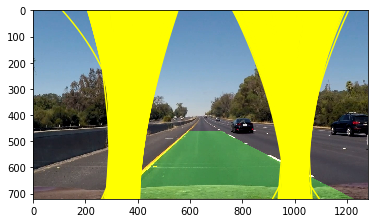

In [25]:
white_output = 'output_video/project_video_output_trial3.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)
